# Imports

In [1]:
import pyspark
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create pyspark session

In [2]:
spark = SparkSession.builder \
    .appName("Houce Price prediciton") \
    .master("local[*]") \
    .config("spark.driver.memory", "20g") \
    .config("spark.executor.memory", "20g") \
    .config("spark.executor.cores", "6") \
    .config("spark.driver.cores", "6") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "10g") \
    .config('spark.driver.maxResultsSize',"10g") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()

print("Spark session created with custom configurations.")

Spark session created with custom configurations.


# Import dataset

In [3]:
dfs_house=spark.read.csv('../data/kc_house_data.csv',header=True,inferSchema=True)

In [4]:
dfs_house.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)




### Dataset Variable Descriptions

- **id** : Unique identifier for each property sale.
- **date** : Date of the home sale, formatted as a string.
- **price** : Sale price of each home, which is the target variable for prediction.
- **bedrooms** : Number of bedrooms in the house.
- **bathrooms** : Number of bathrooms in the house, including partial bathrooms.
- **sqft_living** : Square footage of the interior living space.
- **sqft_lot** : Square footage of the lot.
- **floors** : Number of floors in the property.
- **waterfront** : Binary indicator of whether the property has a waterfront view (1 = yes, 0 = no).
- **view** : An index from 0 to 4 indicating the quality of the view.
- **condition** : Overall condition rating of the property, on a scale from 1 to 5.
- **grade** : An index from 1 to 13 indicating the construction and design quality of the property, with higher values representing better quality.
- **sqft_above** : Square footage of the house above ground level.
- **sqft_basement** : Square footage of the basement in the property.
- **yr_built** : Year the property was built.
- **yr_renovated** : Year of the most recent renovation. A value of 0 indicates no renovation.
- **zipcode** : ZIP code of the property, representing its location.
- **lat** : Latitude coordinate of the property.
- **long** : Longitude coordinate of the property.
- **sqft_living15** : Average square footage of living space for the 15 nearest neighboring properties.
- **sqft_lot15** : Average square footage of the lot for the 15 nearest neighboring properties.

## Persist and count

In [5]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()

21613

With 21613 values, the use of pyspark seems appropriate, and its possible to persist the dataframe

In [6]:
dfs_house.show()

+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|           date|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000| 221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|20141209T000000| 538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7|      2170|          40

# Cleaning

### Check null values

In [7]:
for column in dfs_house.columns:
    null_count = dfs_house.filter(col(column).isNull()).count()
    if null_count > 0:
        print(f"Column '{column}' has {null_count} null values.")
    else:
        print(f"Column '{column}' has no null values.")

Column 'id' has no null values.
Column 'date' has no null values.
Column 'price' has no null values.
Column 'bedrooms' has no null values.
Column 'bathrooms' has no null values.
Column 'sqft_living' has no null values.
Column 'sqft_lot' has no null values.
Column 'floors' has no null values.
Column 'waterfront' has no null values.
Column 'view' has no null values.
Column 'condition' has no null values.
Column 'grade' has no null values.
Column 'sqft_above' has no null values.
Column 'sqft_basement' has no null values.
Column 'yr_built' has no null values.
Column 'yr_renovated' has no null values.
Column 'zipcode' has no null values.
Column 'lat' has no null values.
Column 'long' has no null values.
Column 'sqft_living15' has no null values.
Column 'sqft_lot15' has no null values.


### Unique ids

In [8]:
duplicate_ids = dfs_house.groupBy("id").count().filter(col("count") > 1)

# Afficher les doublons s'il y en a
if duplicate_ids.count() > 0:
    print(f"Il existe {duplicate_ids.count()} doublons dans la colonne 'id'. Voici les ids en double :")
    duplicate_ids.show()
else:
    print("Aucun doublon n'a été trouvé dans la colonne 'id'.")

Il existe 176 doublons dans la colonne 'id'. Voici les ids en double :
+----------+-----+
|        id|count|
+----------+-----+
|2023049218|    2|
|2787460720|    2|
|7853400250|    2|
|8121100395|    2|
| 123039336|    2|
|6021501535|    2|
|3333002450|    2|
| 641900050|    2|
|1825069031|    2|
|2019200220|    2|
|3578401060|    2|
|8910500150|    2|
|7409700215|    2|
|8820903380|    2|
|4443800385|    2|
|7899800045|    2|
|4204400098|    2|
|3523069060|    2|
|   1000102|    2|
|8682262400|    2|
+----------+-----+
only showing top 20 rows



In [9]:
duplicates_df = dfs_house.join(duplicate_ids, on="id", how="inner")

duplicates_dfs = duplicates_df.groupBy(dfs_house.columns).count().filter(col("count") > 1)

if duplicates_dfs.count() > 0:
    print("Certaines lignes avec des IDs en double sont entièrement identiques.")
    duplicates_dfs.show()
else:
    print("Les lignes avec des IDs en double ne sont pas identiques.")

Les lignes avec des IDs en double ne sont pas identiques.


It looks like some house have been sold at least 2 times in a year

In [10]:
duplicates_df.show()

+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+-----+
|        id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|count|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+-----+
|2023049218|20150316T000000|445000.0|       2|      1.0|        930|    7740|   1.0|         0|   0|        1|    5|       930|            0|    1932|           0|  98148|47.4611|-122.324|         1620|      8584|    2|
|2023049218|20140716T000000|105500.0|       2|      1.0|        930|    7740|   1.0|         0|   0|        1|    5|    

### Comparison price

In [11]:
duplicates_df = duplicates_df.withColumn("date_ts", F.to_timestamp(F.col("date").substr(1, 8), "yyyyMMdd"))

window_spec = Window.partitionBy("id").orderBy("date_ts")

duplicates_df = duplicates_df.withColumn("row_num", F.row_number().over(window_spec))

first_sale_df = duplicates_df.filter(F.col("row_num") == 1).select('id','date','price')
second_sale_df = duplicates_df.filter(F.col("row_num") == 2).select('id','date','price')

first_sale_df.show(truncate=False)
second_sale_df.show(truncate=False)

+----------+---------------+--------+
|id        |date           |price   |
+----------+---------------+--------+
|1000102   |20140916T000000|280000.0|
|7200179   |20141016T000000|150000.0|
|109200390 |20140820T000000|245000.0|
|123039336 |20140611T000000|148000.0|
|251300110 |20140731T000000|225000.0|
|302000375 |20140814T000000|169100.0|
|324000530 |20140708T000000|201500.0|
|526059224 |20140923T000000|260000.0|
|641900050 |20140819T000000|335000.0|
|643300040 |20141104T000000|481000.0|
|705730280 |20140819T000000|325000.0|
|722039087 |20140923T000000|220500.0|
|723049156 |20140523T000000|149000.0|
|726049190 |20141002T000000|287500.0|
|795000620 |20140924T000000|115000.0|
|937000330 |20141224T000000|157000.0|
|1036400200|20150213T000000|661000.0|
|1139600270|20140701T000000|300000.0|
|1217000340|20140606T000000|185000.0|
|1219000473|20140626T000000|164950.0|
+----------+---------------+--------+
only showing top 20 rows

+----------+---------------+--------+
|id        |date        

In [12]:
first_sale_df = first_sale_df.withColumnRenamed("date", "first_date") \
                             .withColumnRenamed("price", "first_sale_price")

second_sale_df = second_sale_df.withColumnRenamed("date", "second_date") \
                               .withColumnRenamed("price", "second_sale_price")

combined_dfs = first_sale_df.join(second_sale_df, on="id", how="inner")
combined_dfs = combined_dfs.withColumn("price_difference", F.col("second_sale_price") - F.col("first_sale_price"))

combined_dfs.show(truncate=False)

+----------+---------------+----------------+---------------+-----------------+----------------+
|id        |first_date     |first_sale_price|second_date    |second_sale_price|price_difference|
+----------+---------------+----------------+---------------+-----------------+----------------+
|1000102   |20140916T000000|280000.0        |20150422T000000|300000.0         |20000.0         |
|7200179   |20141016T000000|150000.0        |20150424T000000|175000.0         |25000.0         |
|109200390 |20140820T000000|245000.0        |20141020T000000|250000.0         |5000.0          |
|123039336 |20140611T000000|148000.0        |20141208T000000|244900.0         |96900.0         |
|251300110 |20140731T000000|225000.0        |20150114T000000|358000.0         |133000.0        |
|302000375 |20140814T000000|169100.0        |20150506T000000|250000.0         |80900.0         |
|324000530 |20140708T000000|201500.0        |20150323T000000|459000.0         |257500.0        |
|526059224 |20140923T000000|26

In [13]:
combined_dfs.persist(StorageLevel.MEMORY_AND_DISK).count()

176

In [14]:
average_price = combined_dfs.agg(F.avg("first_sale_price")).first()[0]

# Define a margin as 2% of the average price
negligible_margin = average_price * 0.03

combined_df = combined_dfs.withColumn(
    "is_negligible", F.abs(F.col("price_difference")) <= negligible_margin
)

negligible_df = combined_df.filter(F.col("is_negligible") == True)
negligible_df.show(truncate=False)
negligible_df.count()

+----------+---------------+----------------+---------------+-----------------+----------------+-------------+
|id        |first_date     |first_sale_price|second_date    |second_sale_price|price_difference|is_negligible|
+----------+---------------+----------------+---------------+-----------------+----------------+-------------+
|1825069031|20140814T000000|550000.0        |20141016T000000|550000.0         |0.0             |true         |
|8682262400|20140718T000000|430000.0        |20150513T000000|419950.0         |-10050.0        |true         |
|795000620 |20140924T000000|115000.0        |20141215T000000|124000.0         |9000.0          |true         |
|9222400605|20141115T000000|842500.0        |20150411T000000|850000.0         |7500.0          |true         |
|7701960990|20140616T000000|862000.0        |20140819T000000|870000.0         |8000.0          |true         |
|1139600270|20140701T000000|300000.0        |20150324T000000|310000.0         |10000.0         |true         |
|

13

#### Filter out the found duplicates

In [15]:
negligible_ids=negligible_df.select('id')
dfs_house = dfs_house.join(negligible_ids, on="id", how="left_anti")
dfs_house.show(truncate=False)
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()
combined_dfs.unpersist()

+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|id        |date           |price    |bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat    |long    |sqft_living15|sqft_lot15|
+----------+---------------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|221900.0 |3       |1.0      |1180       |5650    |1.0   |0         |0   |3        |7    |1180      |0            |1955    |0           |98178  |47.5112|-122.257|1340         |5650      |
|6414100192|20141209T000000|538000.0 |3       |2.25     |2570       |7242    |2.0   |0         |0   |3        |7    |2170      |400         

DataFrame[id: bigint, first_date: string, first_sale_price: double, second_date: string, second_sale_price: double, price_difference: double]

### Clean bathroom and floors data

In [16]:
dfs_house = dfs_house.withColumn("bathrooms", F.round(F.col("bathrooms")).cast("integer")) \
                     .withColumn("floors", F.round(F.col("floors")).cast("integer"))

dfs_house.select("bathrooms", "floors").show(truncate=False)

+---------+------+
|bathrooms|floors|
+---------+------+
|1        |1     |
|2        |2     |
|1        |1     |
|3        |1     |
|2        |1     |
|5        |1     |
|2        |2     |
|2        |1     |
|1        |1     |
|3        |2     |
|3        |1     |
|1        |1     |
|1        |2     |
|2        |1     |
|2        |2     |
|3        |2     |
|2        |2     |
|1        |2     |
|1        |1     |
|1        |1     |
+---------+------+
only showing top 20 rows



In [17]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[id: bigint, date: string, price: double, bedrooms: int, bathrooms: int, sqft_living: int, sqft_lot: int, floors: int, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int]

In [18]:
dfs_house.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



# Transform dataset

### Date

In [19]:
dfs_house = dfs_house.withColumn("dateTime", F.to_timestamp(F.col("date").substr(1, 8), "yyyyMMdd")) \
                     .withColumn("year_of_sale", F.year("dateTime"))

# Show the resulting DataFrame with the new columns
dfs_house.select("date", "dateTime", "year_of_sale").show(truncate=False)

+---------------+-------------------+------------+
|date           |dateTime           |year_of_sale|
+---------------+-------------------+------------+
|20141013T000000|2014-10-13 00:00:00|2014        |
|20141209T000000|2014-12-09 00:00:00|2014        |
|20150225T000000|2015-02-25 00:00:00|2015        |
|20141209T000000|2014-12-09 00:00:00|2014        |
|20150218T000000|2015-02-18 00:00:00|2015        |
|20140512T000000|2014-05-12 00:00:00|2014        |
|20140627T000000|2014-06-27 00:00:00|2014        |
|20150115T000000|2015-01-15 00:00:00|2015        |
|20150415T000000|2015-04-15 00:00:00|2015        |
|20150312T000000|2015-03-12 00:00:00|2015        |
|20150403T000000|2015-04-03 00:00:00|2015        |
|20140527T000000|2014-05-27 00:00:00|2014        |
|20140528T000000|2014-05-28 00:00:00|2014        |
|20141007T000000|2014-10-07 00:00:00|2014        |
|20150312T000000|2015-03-12 00:00:00|2015        |
|20150124T000000|2015-01-24 00:00:00|2015        |
|20140731T000000|2014-07-31 00:

In [20]:
reference_date = F.to_date(F.lit("2014-05-01")) #la dataset répertorie les ventes à partir de Mai2014

dfs_house = dfs_house.withColumn("number_of_days", F.datediff(F.col("dateTime"), reference_date))

dfs_house.select("date", "dateTime", "number_of_days").show(truncate=False)

+---------------+-------------------+--------------+
|date           |dateTime           |number_of_days|
+---------------+-------------------+--------------+
|20141013T000000|2014-10-13 00:00:00|165           |
|20141209T000000|2014-12-09 00:00:00|222           |
|20150225T000000|2015-02-25 00:00:00|300           |
|20141209T000000|2014-12-09 00:00:00|222           |
|20150218T000000|2015-02-18 00:00:00|293           |
|20140512T000000|2014-05-12 00:00:00|11            |
|20140627T000000|2014-06-27 00:00:00|57            |
|20150115T000000|2015-01-15 00:00:00|259           |
|20150415T000000|2015-04-15 00:00:00|349           |
|20150312T000000|2015-03-12 00:00:00|315           |
|20150403T000000|2015-04-03 00:00:00|337           |
|20140527T000000|2014-05-27 00:00:00|26            |
|20140528T000000|2014-05-28 00:00:00|27            |
|20141007T000000|2014-10-07 00:00:00|159           |
|20150312T000000|2015-03-12 00:00:00|315           |
|20150124T000000|2015-01-24 00:00:00|268      

In [21]:
dfs_house=dfs_house.drop('date','dateTime')
dfs_house.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[id: bigint, price: double, bedrooms: int, bathrooms: int, sqft_living: int, sqft_lot: int, floors: int, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int, year_of_sale: int, number_of_days: int]

In [22]:
dfs_house = dfs_house.withColumn("age_house", F.col("year_of_sale") - F.col("yr_built"))
dfs_house = dfs_house.withColumn(
    "yr_renovated",
    F.when(F.col("yr_renovated") == 0, F.col("yr_built")).otherwise(F.col("yr_renovated"))
)
dfs_house = dfs_house.withColumn("year_since_renovation", F.col("year_of_sale") - F.col("yr_renovated"))

dfs_house.select("yr_built", "year_of_sale", "age_house","year_since_renovation",'yr_renovated').show(truncate=False)

+--------+------------+---------+---------------------+------------+
|yr_built|year_of_sale|age_house|year_since_renovation|yr_renovated|
+--------+------------+---------+---------------------+------------+
|1955    |2014        |59       |59                   |1955        |
|1951    |2014        |63       |23                   |1991        |
|1933    |2015        |82       |82                   |1933        |
|1965    |2014        |49       |49                   |1965        |
|1987    |2015        |28       |28                   |1987        |
|2001    |2014        |13       |13                   |2001        |
|1995    |2014        |19       |19                   |1995        |
|1963    |2015        |52       |52                   |1963        |
|1960    |2015        |55       |55                   |1960        |
|2003    |2015        |12       |12                   |2003        |
|1965    |2015        |50       |50                   |1965        |
|1942    |2014        |72       |7

In [23]:
dfs_house=dfs_house.drop('yr_built','year_of_sale','yr_renovated')
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).show()

+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------+--------+-------------+----------+--------------+---------+---------------------+
|        id|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|zipcode|    lat|    long|sqft_living15|sqft_lot15|number_of_days|age_house|year_since_renovation|
+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------+--------+-------------+----------+--------------+---------+---------------------+
|7129300520| 221900.0|       3|        1|       1180|    5650|     1|         0|   0|        3|    7|      1180|            0|  98178|47.5112|-122.257|         1340|      5650|           165|       59|                   59|
|6414100192| 538000.0|       3|        2|       2570|    7242|     2|         0|   0|        3|    7|   

### Localisation

#### Density pop and city name by zip code

I will first import another dataset to add data (from simplemaps)

In [24]:
dfs_zip_us=spark.read.csv('../data/uszips_updated.csv',header=True,inferSchema=True)
dfs_zip_us.printSchema()

root
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- zcta: boolean (nullable = true)
 |-- parent_zcta: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- density: double (nullable = true)
 |-- county_fips: integer (nullable = true)
 |-- county_name: string (nullable = true)
 |-- county_weights: string (nullable = true)
 |-- county_names_all: string (nullable = true)
 |-- county_fips_all: string (nullable = true)
 |-- imprecise: string (nullable = true)
 |-- military: string (nullable = true)
 |-- timezone: string (nullable = true)



In [25]:
#We filter out to only keep zip from the King County in WA
dfs_zip_us=dfs_zip_us.filter(col('county_name')=='King')
dfs_zip_us=dfs_zip_us.filter(col('state_id')=='WA')
dfs_zip_us.show()
dfs_zip_us.persist(StorageLevel.MEMORY_AND_DISK).count()

+-----+--------+----------+-------------+--------+----------+----+-----------+----------+-------+-----------+-----------+------------------+-------------------+---------------+-----------+--------+-------------------+
|  zip|     lat|       lng|         city|state_id|state_name|zcta|parent_zcta|population|density|county_fips|county_name|    county_weights|   county_names_all|county_fips_all|  imprecise|military|           timezone|
+-----+--------+----------+-------------+--------+----------+----+-----------+----------+-------+-----------+-----------+------------------+-------------------+---------------+-----------+--------+-------------------+
|98001|47.30919|-122.26426|       Auburn|      WA|Washington|true|       NULL|     35842|  742.6|      53033|       King|"{""53033"": 100}"|               King|          53033|      FALSE|   FALSE|America/Los_Angeles|
|98002| 47.3082|-122.21567|       Auburn|      WA|Washington|true|       NULL|     36812| 1984.0|      53033|       King|"{""530

86

In [26]:
dfs_zip_us=dfs_zip_us.select('zip','population','density','city')
dfs_zip_us.show()

+-----+----------+-------+-------------+
|  zip|population|density|         city|
+-----+----------+-------+-------------+
|98001|     35842|  742.6|       Auburn|
|98002|     36812| 1984.0|       Auburn|
|98003|     51329| 1723.2|  Federal Way|
|98004|     39161| 2079.8|     Bellevue|
|98005|     22030| 1159.1|     Bellevue|
|98006|     39753| 1365.6|     Bellevue|
|98007|     27571| 2464.1|     Bellevue|
|98008|     27060| 1879.5|     Bellevue|
|98010|      6128|  159.2|Black Diamond|
|98011|     27573| 1509.1|      Bothell|
|98014|      7626|   33.8|    Carnation|
|98019|     11281|  122.1|       Duvall|
|98022|     22163|   11.8|     Enumclaw|
|98023|     50778| 1910.0|  Federal Way|
|98024|      5066|   88.6|    Fall City|
|98025|         0|    0.0|       Hobart|
|98027|     27915|  188.5|     Issaquah|
|98028|     23611| 1482.9|      Kenmore|
|98029|     31227| 1185.1|     Issaquah|
|98030|     38798| 2083.5|         Kent|
+-----+----------+-------+-------------+
only showing top

### Merge the two dataset

In [27]:
dfs_house = dfs_house.join(
    dfs_zip_us.select("zip", "population", "density", "city"),
    dfs_house["zipcode"] == dfs_zip_us["zip"],
    "left"
)

In [28]:
dfs_house=dfs_house.drop('lat','long')
dfs_house.show()

+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------------+----------+--------------+---------+---------------------+-----+----------+-------+------------+
|        id|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|zipcode|sqft_living15|sqft_lot15|number_of_days|age_house|year_since_renovation|  zip|population|density|        city|
+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------------+----------+--------------+---------+---------------------+-----+----------+-------+------------+
|7129300520| 221900.0|       3|        1|       1180|    5650|     1|         0|   0|        3|    7|      1180|            0|  98178|         1340|      5650|           165|       59|                   59|98178|     26760| 2108.1|     Seattle|
|6414100192| 538000.

In [29]:
dfs_house = dfs_house.withColumnRenamed("population", "zip_population") \
                     .withColumnRenamed("density", "zip_density")

Check if null values have been introduced

In [30]:
null_or_zero_df = dfs_house.filter(
    (F.col("zip_population").isNull()) | (F.col("zip_population") == 0) |
    (F.col("zip_density").isNull()) | (F.col("zip_density") == 0)
)

null_or_zero_df.select("zipcode", "zip_population", "zip_density").show(truncate=False)

+-------+--------------+-----------+
|zipcode|zip_population|zip_density|
+-------+--------------+-----------+
+-------+--------------+-----------+



In [31]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()

21586

dataset_link = https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2015-zip-code-data-soi

### Add tax data

In [32]:
dfs_tax=spark.read.csv('../../tax_us_2015/tax_us_zip.csv',inferSchema=True,header=True)
dfs_tax.printSchema()

root
 |-- STATEFIPS: integer (nullable = true)
 |-- STATE: string (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- agi_stub: integer (nullable = true)
 |-- N1: double (nullable = true)
 |-- mars1: double (nullable = true)
 |-- MARS2: double (nullable = true)
 |-- MARS4: double (nullable = true)
 |-- PREP: double (nullable = true)
 |-- N2: double (nullable = true)
 |-- NUMDEP: double (nullable = true)
 |-- TOTAL_VITA: double (nullable = true)
 |-- VITA: double (nullable = true)
 |-- TCE: double (nullable = true)
 |-- VITA_EIC: double (nullable = true)
 |-- RAL: double (nullable = true)
 |-- RAC: double (nullable = true)
 |-- ELDERLY: double (nullable = true)
 |-- A00100: double (nullable = true)
 |-- N02650: double (nullable = true)
 |-- A02650: double (nullable = true)
 |-- N00200: double (nullable = true)
 |-- A00200: double (nullable = true)
 |-- N00300: double (nullable = true)
 |-- A00300: double (nullable = true)
 |-- N00600: double (nullable = true)
 |-- A00600: dou

In [33]:
dfs_tax=dfs_tax.filter(col('STATE')=='WA')
dfs_tax=dfs_tax.select(
    col("zipcode").alias("zip_code"),
    col("N1").alias("num_households"),
    col("agi_stub").alias("income_bracket"),
    col("A00100").alias("adjusted_gross_income"),
    col("A00200").alias("wages_and_salaries"),
    col("A00600").alias("dividends"),
    col("A00900").alias("interest_received")
)
dfs_tax.persist(StorageLevel.MEMORY_AND_DISK).count()
dfs_tax.show()

+--------+--------------+--------------+---------------------+------------------+---------+-----------------+
|zip_code|num_households|income_bracket|adjusted_gross_income|wages_and_salaries|dividends|interest_received|
+--------+--------------+--------------+---------------------+------------------+---------+-----------------+
|       0|     1031890.0|             1|          1.3012107E7|       1.0156434E7| 205136.0|         825300.0|
|       0|      802420.0|             2|          2.9258724E7|       2.3636339E7| 275271.0|         984373.0|
|       0|      499800.0|             3|          3.0815121E7|       2.3643076E7| 363644.0|         849102.0|
|       0|      342590.0|             4|          2.9730195E7|       2.2397453E7| 391871.0|         763796.0|
|       0|      525250.0|             5|          7.1538405E7|       5.4477394E7|1177670.0|        2016651.0|
|       0|      183490.0|             6|          8.5830334E7|       4.5759338E7|3666136.0|        2645261.0|
|   98001|

In [34]:
financial_columns = ["adjusted_gross_income", "wages_and_salaries", "dividends", "interest_received"]

for col in financial_columns:
    dfs_tax = dfs_tax.withColumn(f"{col}_weighted", F.col(col) * F.col("num_households"))

aggregated_df = dfs_tax.groupBy("zip_code").agg(
    *[F.sum(F.col(f"{col}_weighted")).alias(f"sum_{col}") for col in financial_columns],
    F.sum("num_households").alias("total_households")
)

for col in financial_columns:
    aggregated_df = aggregated_df.withColumn(f"{col}_average", F.col(f"sum_{col}") / F.col("total_households"))

final_df = aggregated_df.select("zip_code", *[f"{col}_average" for col in financial_columns])
final_df.show()

+--------+-----------------------------+--------------------------+------------------+-------------------------+
|zip_code|adjusted_gross_income_average|wages_and_salaries_average| dividends_average|interest_received_average|
+--------+-----------------------------+--------------------------+------------------+-------------------------+
|   98271|           124551.55352303523|         92594.04607046071| 865.1388888888889|       2937.8014905149053|
|   98290|            203262.2972972973|        157530.20867379007|2350.9415461973604|        7155.962287869264|
|   98376|            7299.379310344828|         4465.770114942528|229.89655172413794|       432.44827586206895|
|   99130|           3316.2432432432433|         2170.108108108108| 19.35135135135135|         34.7027027027027|
|   98002|           130401.87587523871|        109016.09420751114| 564.5945257797581|        4232.979630808402|
|   98390|            57026.75919732441|         44131.69063545151| 537.9816053511705|       152

In [35]:
final_df.persist(StorageLevel.MEMORY_AND_DISK).count()
dfs_tax.unpersist()

DataFrame[zip_code: int, num_households: double, income_bracket: int, adjusted_gross_income: double, wages_and_salaries: double, dividends: double, interest_received: double, adjusted_gross_income_weighted: double, wages_and_salaries_weighted: double, dividends_weighted: double, interest_received_weighted: double]

#### Merge the two dataset

In [36]:
dfs_house.printSchema()

root
 |-- id: long (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- number_of_days: integer (nullable = true)
 |-- age_house: integer (nullable = true)
 |-- year_since_renovation: integer (nullable = true)
 |-- zip: integer (nullable = true)
 |-- zip_population: integer (nullable = true)
 |-- zip_density: double (nullable = true)
 |-- city: string (nullable = true)



In [37]:
final_df = final_df.withColumnRenamed("zip_code", "zip")
dfs_house = dfs_house.join(final_df, on="zip", how="left")
dfs_house.show()

+-----+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------------+----------+--------------+---------+---------------------+--------------+-----------+------------+-----------------------------+--------------------------+------------------+-------------------------+
|  zip|        id|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|zipcode|sqft_living15|sqft_lot15|number_of_days|age_house|year_since_renovation|zip_population|zip_density|        city|adjusted_gross_income_average|wages_and_salaries_average| dividends_average|interest_received_average|
+-----+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+-------+-------------+----------+--------------+---------+---------------------+--------------+-----------+------------+-----------------------------+--------

In [38]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()
final_df.unpersist()

DataFrame[zip: int, adjusted_gross_income_average: double, wages_and_salaries_average: double, dividends_average: double, interest_received_average: double]

## Drop useless columns

In [39]:
dfs_house.printSchema()
dfs_house.count()

root
 |-- zip: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- number_of_days: integer (nullable = true)
 |-- age_house: integer (nullable = true)
 |-- year_since_renovation: integer (nullable = true)
 |-- zip_population: integer (nullable = true)
 |-- zip_density: double (nullable = true)
 |-- city: string (nullable = true)
 |-- adjusted_gross_income_average: 

21586

In [40]:
columns_to_drop = ["id", "zipcode", "city", "zip"]

dfs_house = dfs_house.drop(*columns_to_drop)

dfs_house.printSchema()

root
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- number_of_days: integer (nullable = true)
 |-- age_house: integer (nullable = true)
 |-- year_since_renovation: integer (nullable = true)
 |-- zip_population: integer (nullable = true)
 |-- zip_density: double (nullable = true)
 |-- adjusted_gross_income_average: double (nullable = true)
 |-- wages_and_salaries_average: double (nullable = true)
 |-- dividends_average: double (nullable = true)
 |-- interes

In [41]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()

21586

# Analysis

In [42]:
key_columns = [
    "price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", 
    "waterfront", "view", "condition", "grade", "sqft_above", "sqft_basement", 
    "sqft_living15", "sqft_lot15", "number_of_days", "age_house", 
    "year_since_renovation", "zip_population", "zip_density", 
    "adjusted_gross_income_average", "wages_and_salaries_average", 
    "dividends_average", "interest_received_average"
]

In [43]:
descriptive_stats = dfs_house.select(key_columns).describe()
descriptive_stats.show(truncate=False)

+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+-----------------+------------------+-----------------------------+--------------------------+------------------+-------------------------+
|summary|price            |bedrooms          |bathrooms         |sqft_living      |sqft_lot          |floors            |waterfront          |view               |condition         |grade            |sqft_above        |sqft_basement     |sqft_living15     |sqft_lot15        |number_of_days    |age_house         |year_since_renovation|zip_population   |zip_density       |adjusted_gross_income_average|wages_and_salaries_average|dividends_average |interest_received_average|
+-------+-----------------+------------------+----

In [44]:
from pyspark.sql.functions import when

# Remplacer les valeurs négatives par 0 pour les colonnes 'age_house' et 'year_since_renovation'
dfs_house = dfs_house \
    .withColumn("age_house", when(dfs_house["age_house"] < 0, 0).otherwise(dfs_house["age_house"])) \
    .withColumn("year_since_renovation", when(dfs_house["year_since_renovation"] < 0, 0).otherwise(dfs_house["year_since_renovation"]))

# Vérification des nouvelles valeurs minimales
dfs_house.select("age_house", "year_since_renovation").describe().show()


+-------+------------------+---------------------+
|summary|         age_house|year_since_renovation|
+-------+------------------+---------------------+
|  count|             21586|                21586|
|   mean|43.325488742703605|     40.9517279718336|
| stddev|29.370772154338024|   28.814460584558734|
|    min|                 0|                    0|
|    max|               115|                  115|
+-------+------------------+---------------------+



In [45]:
descriptive_stats = dfs_house.select(key_columns).describe()
descriptive_stats.show(truncate=False)

+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+-----------------+------------------+-----------------------------+--------------------------+------------------+-------------------------+
|summary|price            |bedrooms          |bathrooms         |sqft_living      |sqft_lot          |floors            |waterfront          |view               |condition         |grade            |sqft_above        |sqft_basement     |sqft_living15     |sqft_lot15        |number_of_days    |age_house         |year_since_renovation|zip_population   |zip_density       |adjusted_gross_income_average|wages_and_salaries_average|dividends_average |interest_received_average|
+-------+-----------------+------------------+----

## Correlation matrix

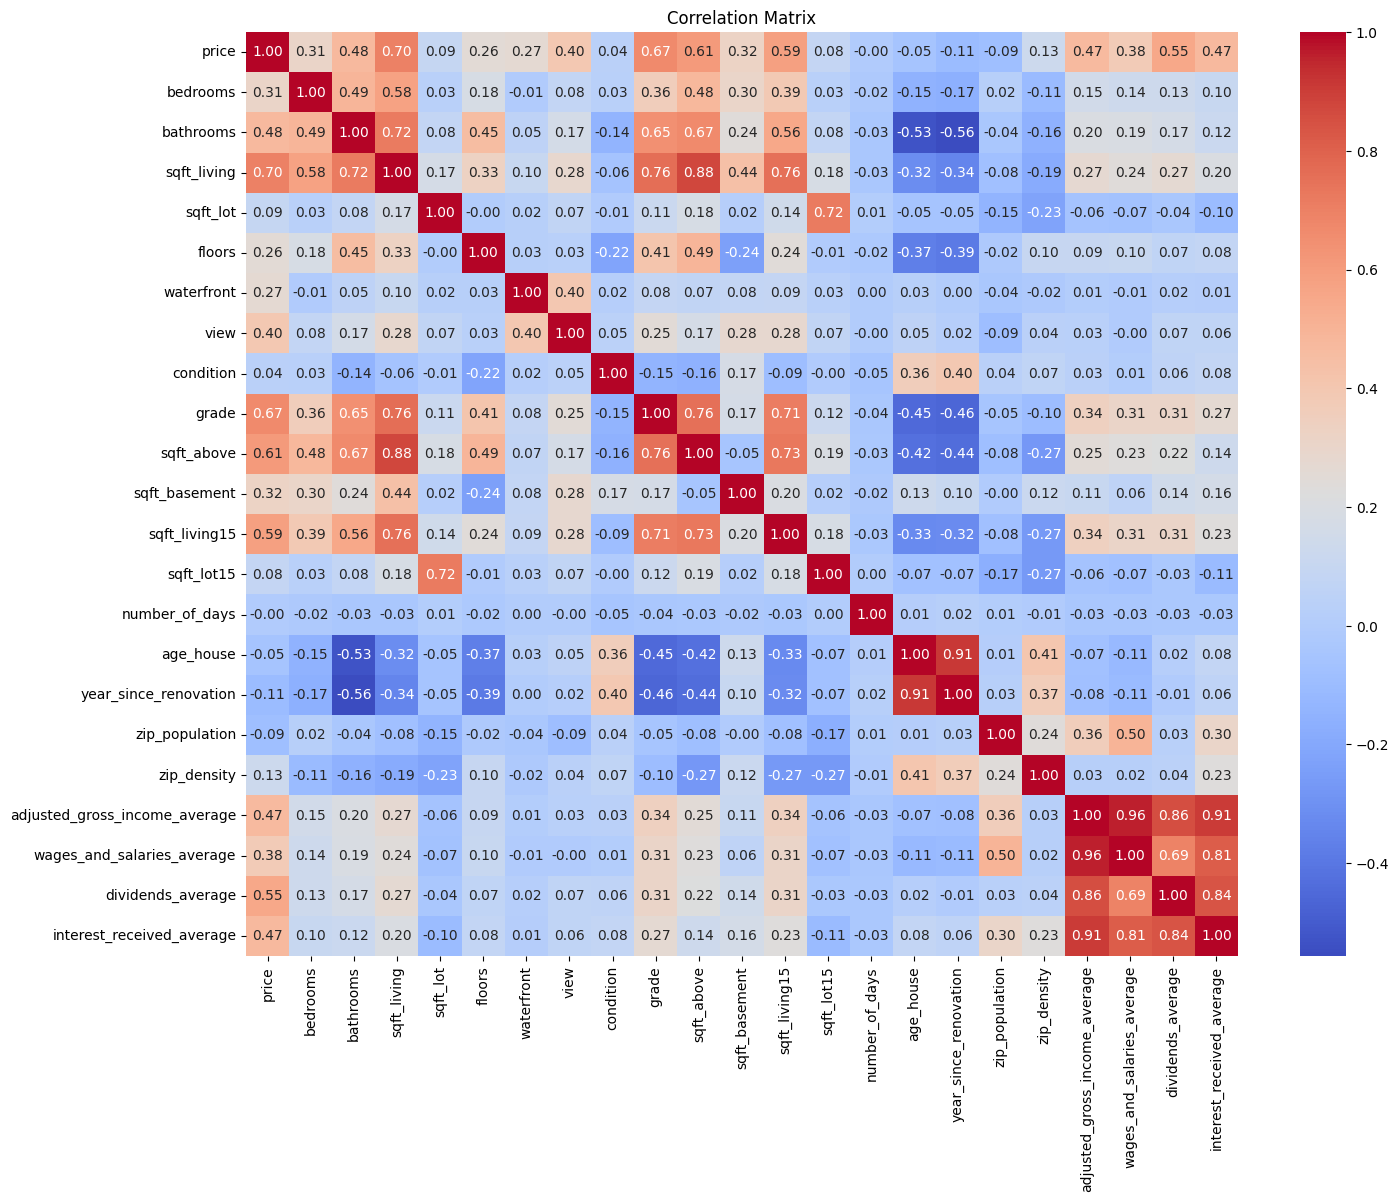

In [46]:
assembler = VectorAssembler(inputCols=dfs_house.columns, outputCol="features")
dfs_house_assembled = assembler.transform(dfs_house).select("features")

correlation_matrix = Correlation.corr(dfs_house_assembled, "features").head()[0].toArray()

corr_df = pd.DataFrame(correlation_matrix, columns=dfs_house.columns, index=dfs_house.columns)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [47]:
corr_df.to_csv("../output/correlation_matrix.csv", index=False)

ajouter cercle de corrélation notament

## Variables exploration

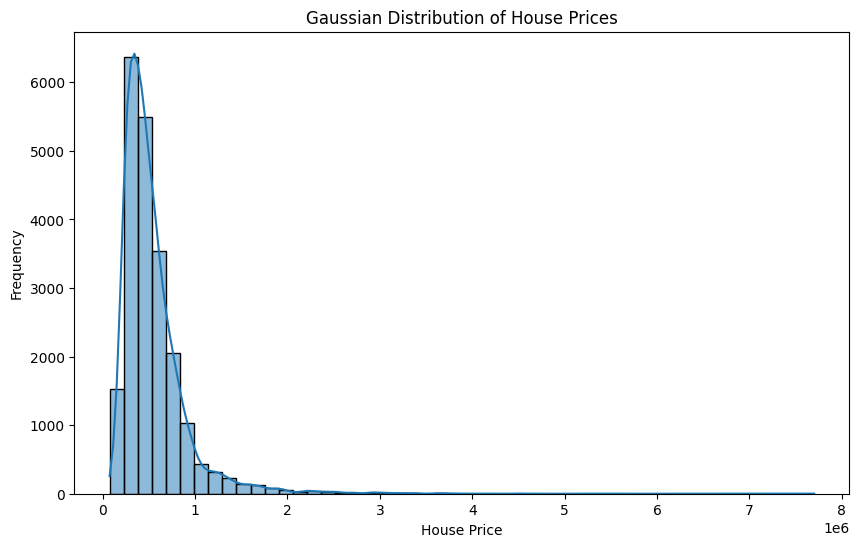

In [48]:
price_data = dfs_house.select("price").toPandas()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(price_data['price'], kde=True, bins=50)
plt.title("Gaussian Distribution of House Prices")
plt.xlabel("House Price")
plt.ylabel("Frequency")
plt.show()

In [49]:
data = dfs_house.select([
    "price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
    "waterfront", "view", "condition", "grade", "sqft_above",
    "sqft_basement", "sqft_living15", "sqft_lot15", "age_house"
]).toPandas()

variables = data.columns.drop("price")

# Create scatter plots for each variable
plt.figure(figsize=(15, 30))

<Figure size 1500x3000 with 0 Axes>

<Figure size 1500x3000 with 0 Axes>

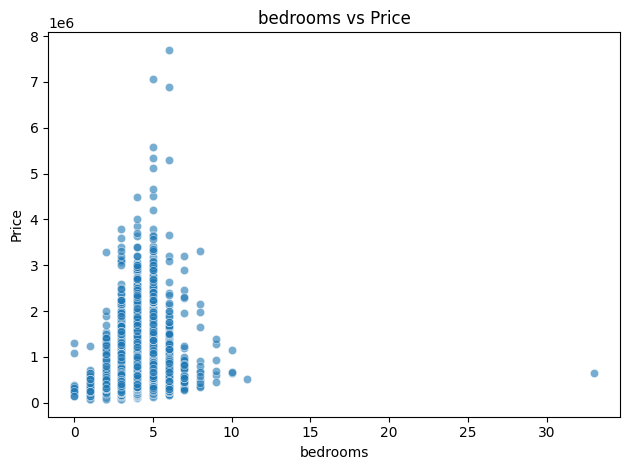

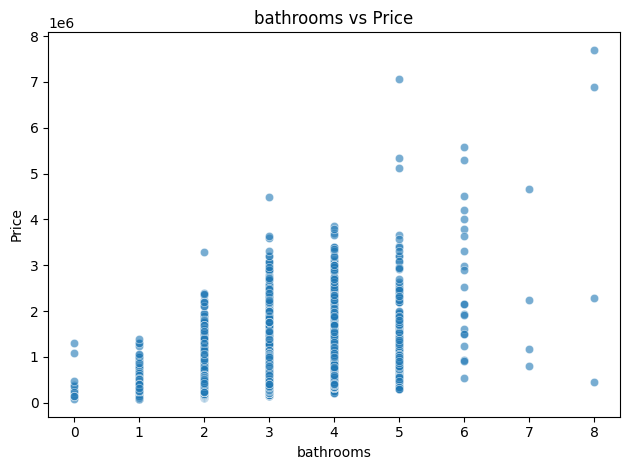

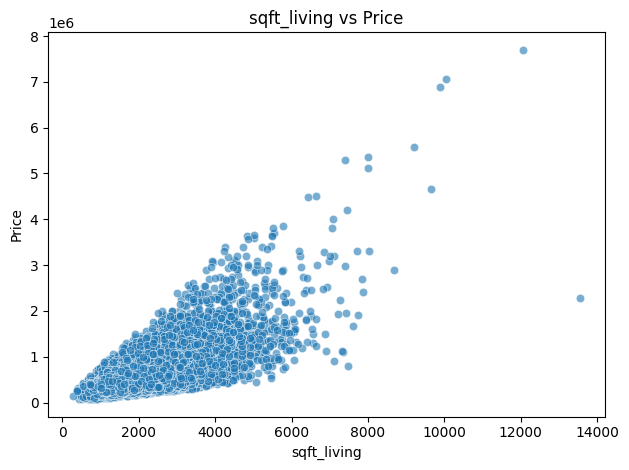

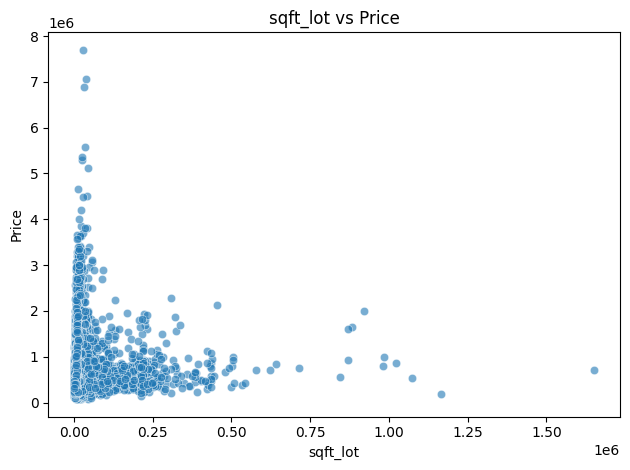

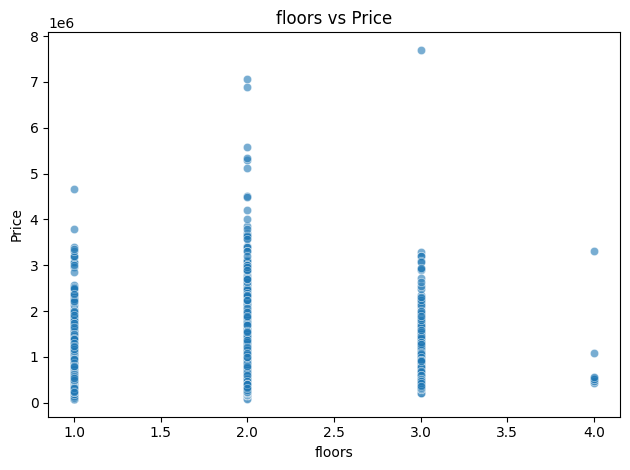

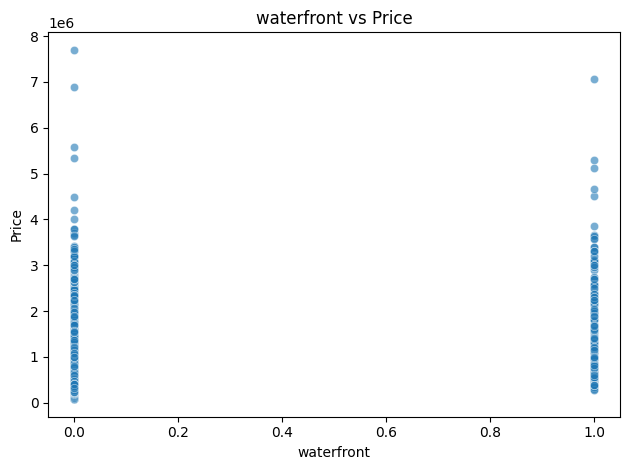

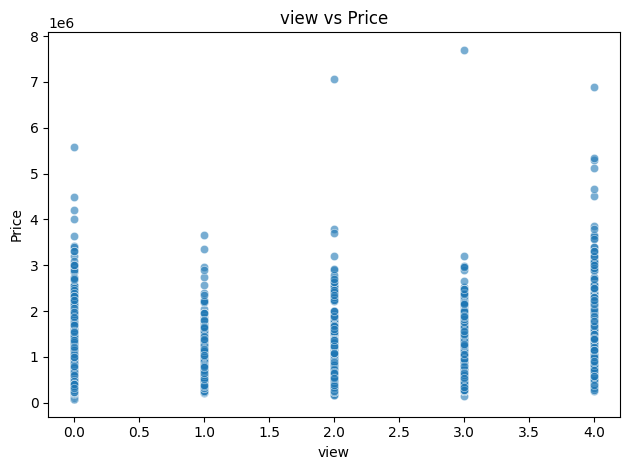

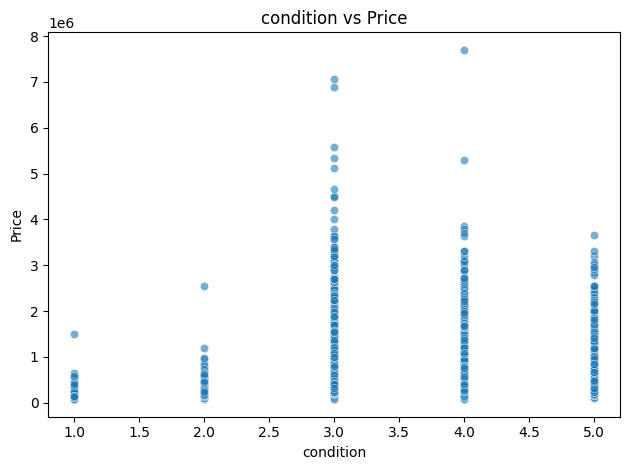

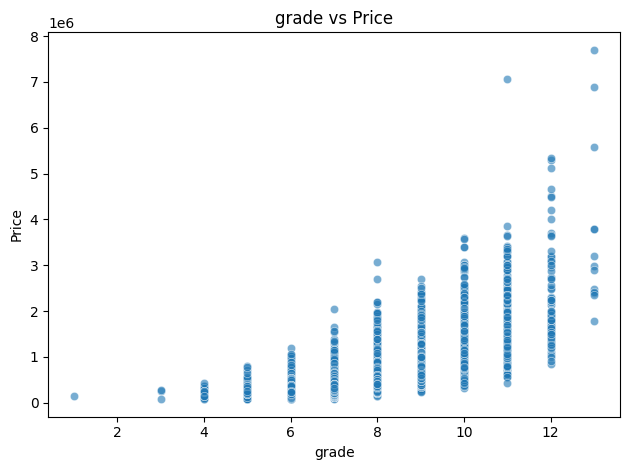

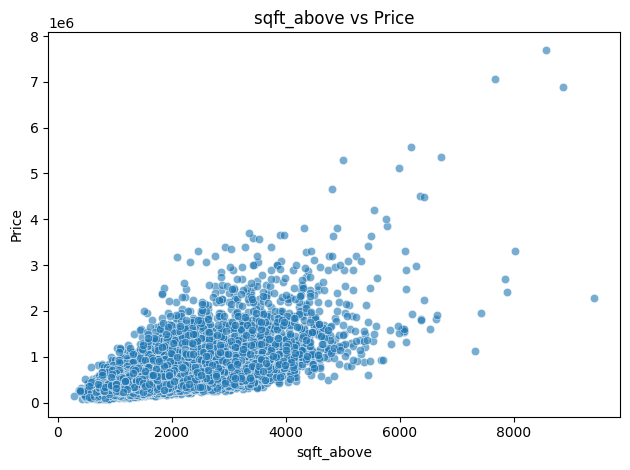

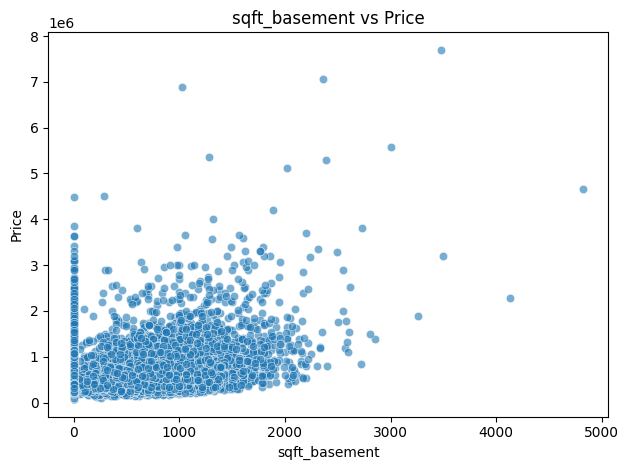

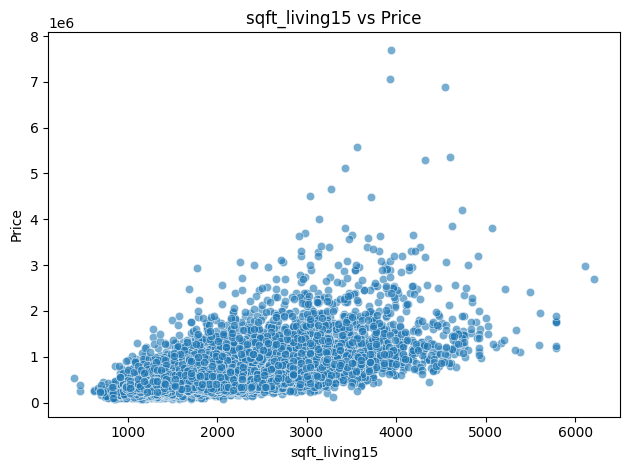

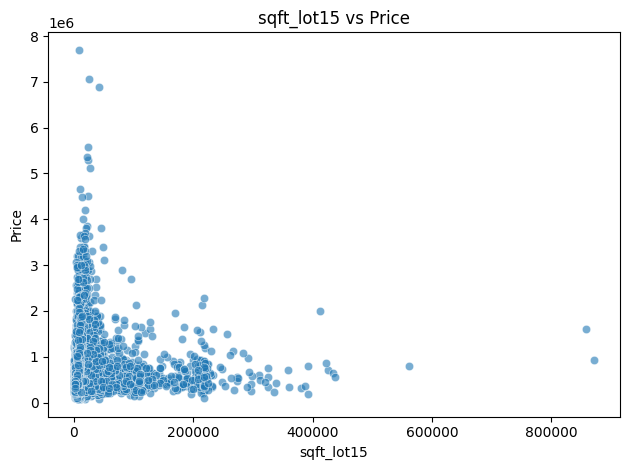

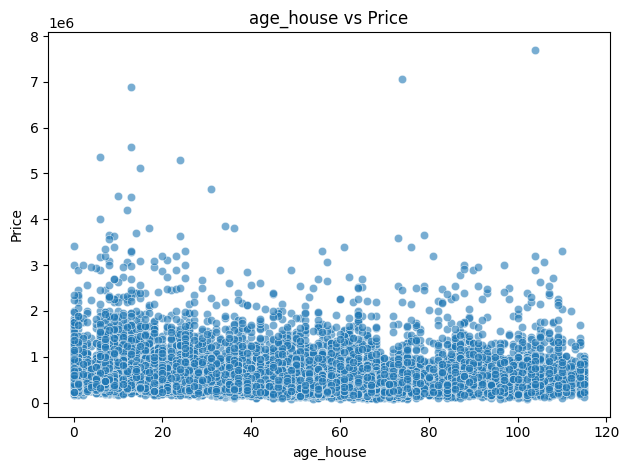

In [50]:
for i, var in enumerate(variables, 1):
    plt.subplot()
    sns.scatterplot(data=data, x=var, y="price", alpha=0.6)
    plt.title(f"{var} vs Price")
    plt.xlabel(var)
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\1975104908.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=var, y="price", inner="box", scale="width", palette="muted")
C:\Users\charl\AppData\Local\Temp\ipykernel_16944\1975104908.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=data, x=var, y="price", inner="box", scale="width", palette="muted")
C:\Users\charl\AppData\Local\Temp\ipykernel_16944\1975104908.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=var, y="price", inner="box", scale="width", palette="muted")
C:\Users\charl\AppData\

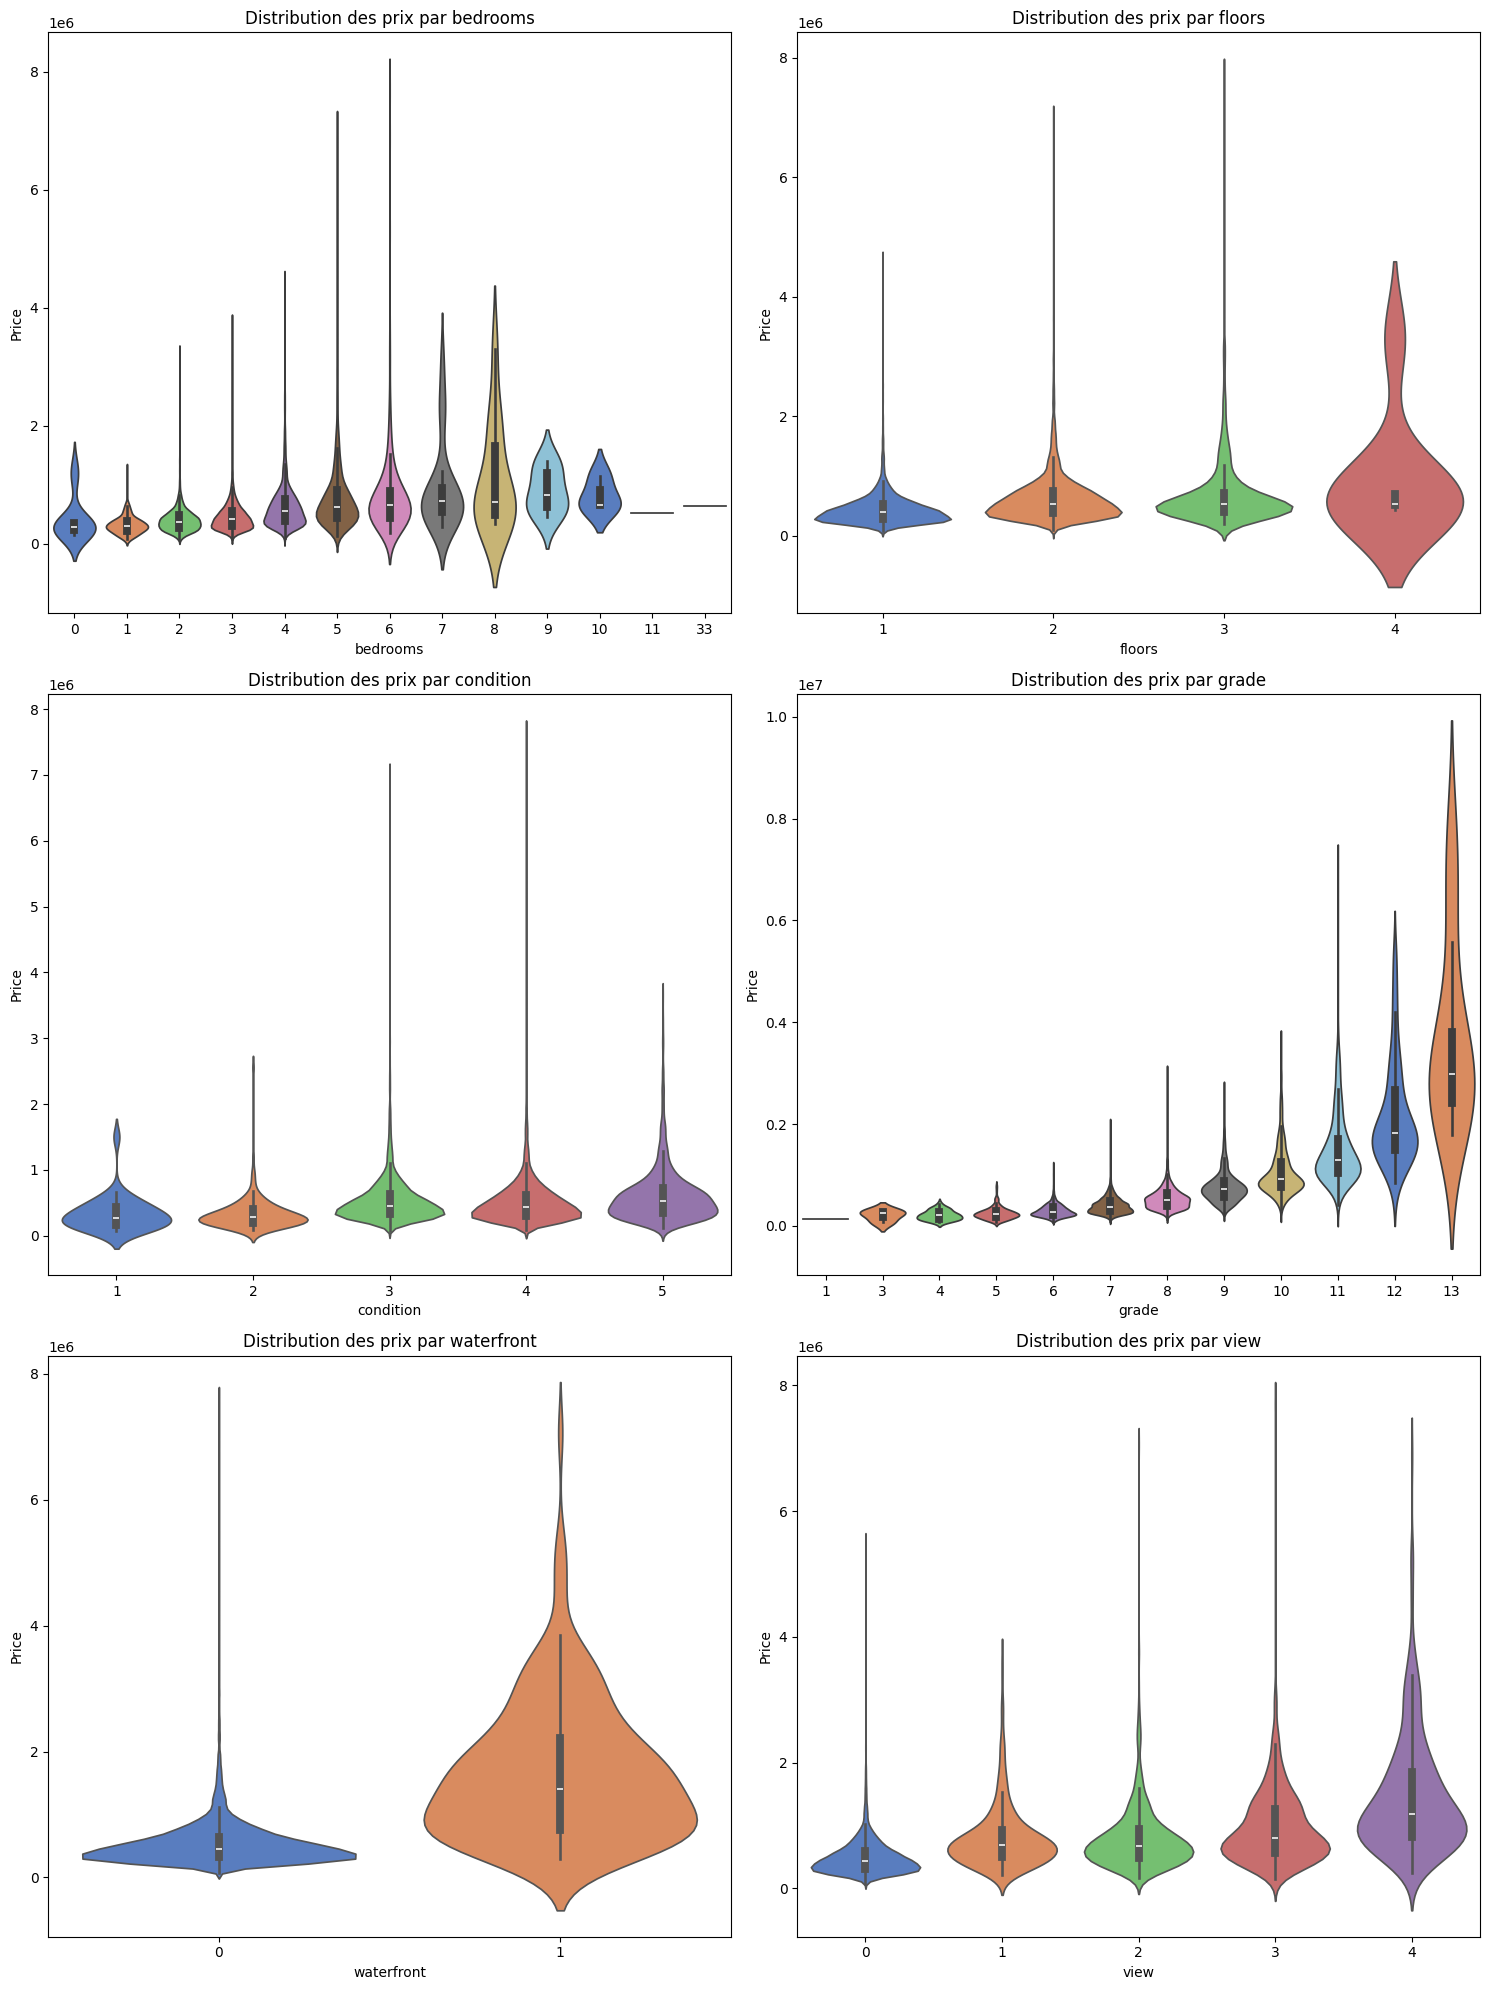

In [51]:
categorical_variables = ["bedrooms", "floors", "condition", "grade", "waterfront", "view"]

plt.figure(figsize=(15, 20))
for i, var in enumerate(categorical_variables, 1):
    plt.subplot(3, 2, i)  # Ajuste la disposition (3 lignes, 2 colonnes)
    sns.violinplot(data=data, x=var, y="price", inner="box", scale="width", palette="muted")
    plt.title(f"Distribution des prix par {var}")
    plt.xlabel(var)
    plt.ylabel("Price")

plt.tight_layout()
plt.show()

### Add price range

In [52]:
dfs_house.printSchema()

root
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- number_of_days: integer (nullable = true)
 |-- age_house: integer (nullable = true)
 |-- year_since_renovation: integer (nullable = true)
 |-- zip_population: integer (nullable = true)
 |-- zip_density: double (nullable = true)
 |-- adjusted_gross_income_average: double (nullable = true)
 |-- wages_and_salaries_average: double (nullable = true)
 |-- dividends_average: double (nullable = true)
 |-- interes

In [53]:
dfs_house = dfs_house.withColumn(
    "price_range",
    when(F.col("price") < 200000, "Low")
    .when((F.col("price") >= 200000) & (F.col("price") < 500000), "Medium")
    .when((F.col("price") >= 500000) & (F.col("price") < 1000000), "High")
    .otherwise("Premium")
)


# Show some samples
dfs_house.select("price", "price_range").show(10)

+---------+-----------+
|    price|price_range|
+---------+-----------+
| 221900.0|     Medium|
| 538000.0|       High|
| 180000.0|        Low|
| 604000.0|       High|
| 510000.0|       High|
|1225000.0|    Premium|
| 257500.0|     Medium|
| 291850.0|     Medium|
| 229500.0|     Medium|
| 323000.0|     Medium|
+---------+-----------+
only showing top 10 rows



In [54]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()

21586

In [55]:
data=dfs_house.toPandas()
columns_to_plot = [
    "price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "waterfront", "view", "condition", "grade",
    "sqft_above", "sqft_basement", "sqft_living15", "sqft_lot15",
    "zip_population", "zip_density"
]

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


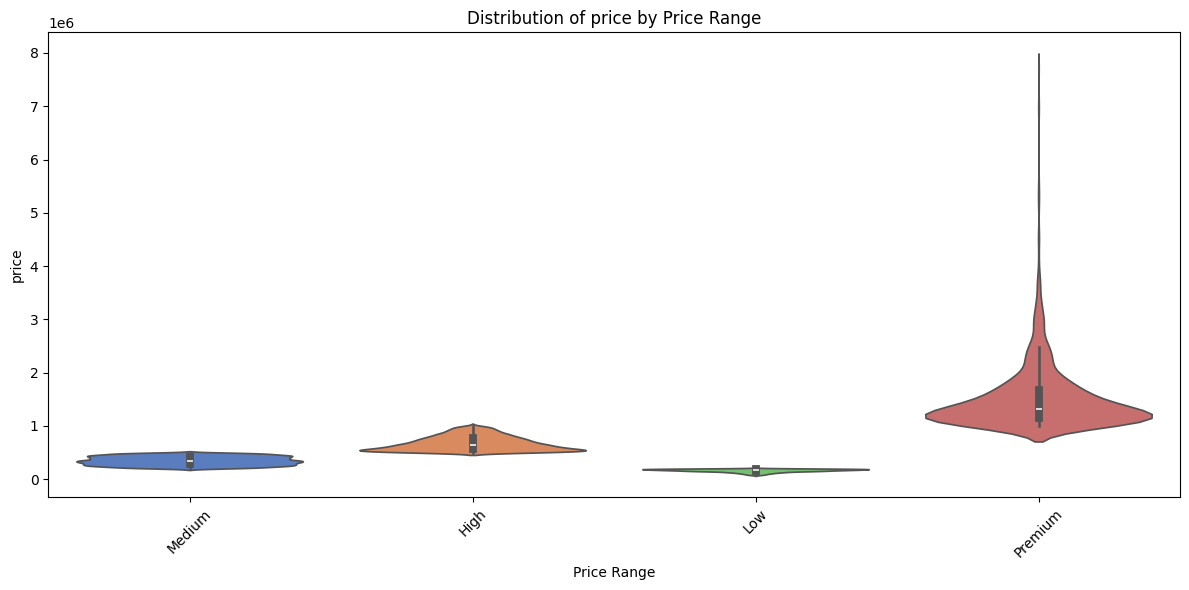

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


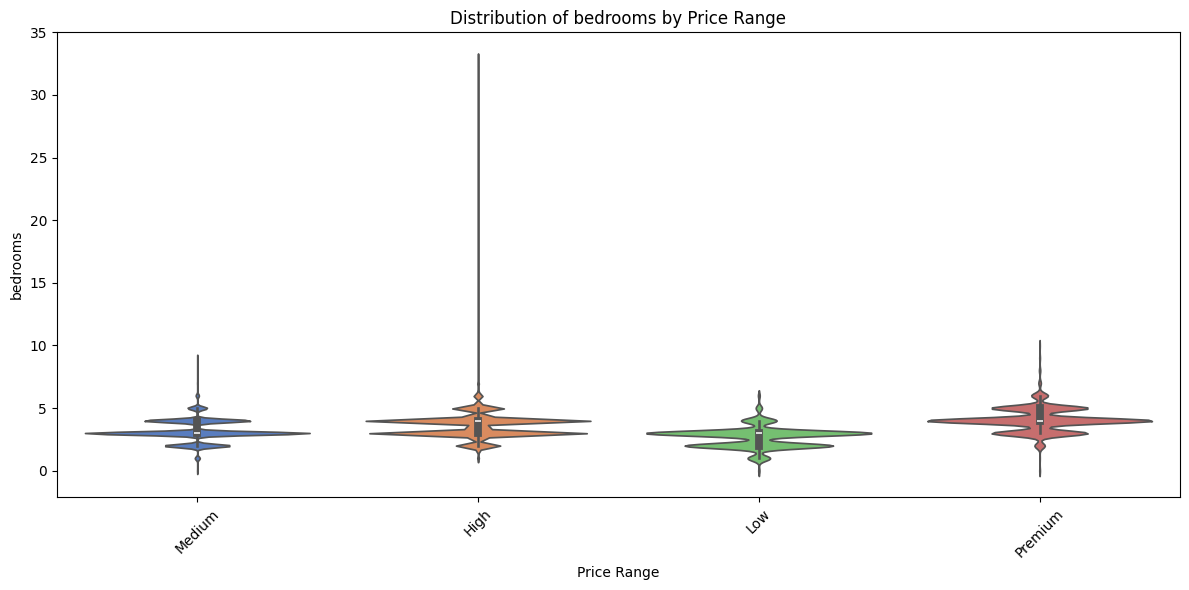

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


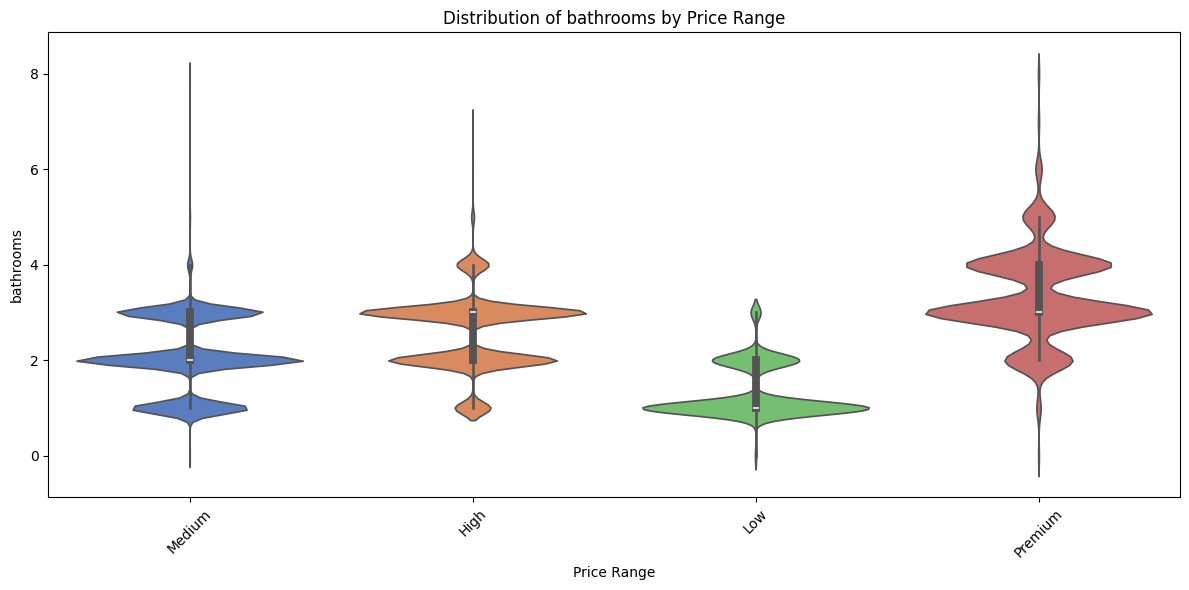

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


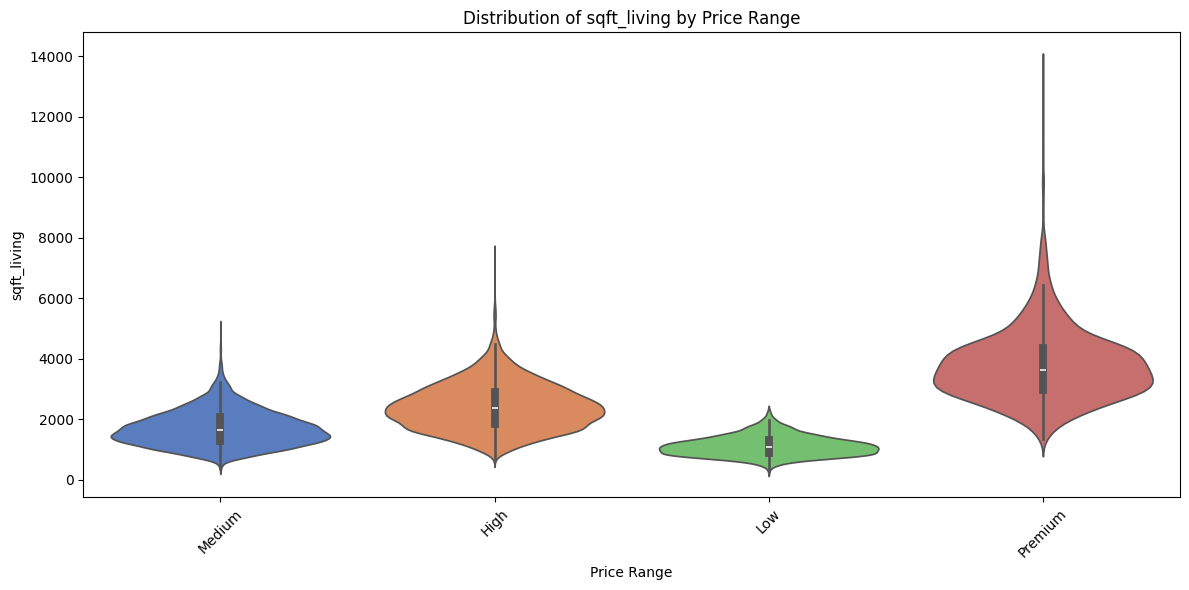

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


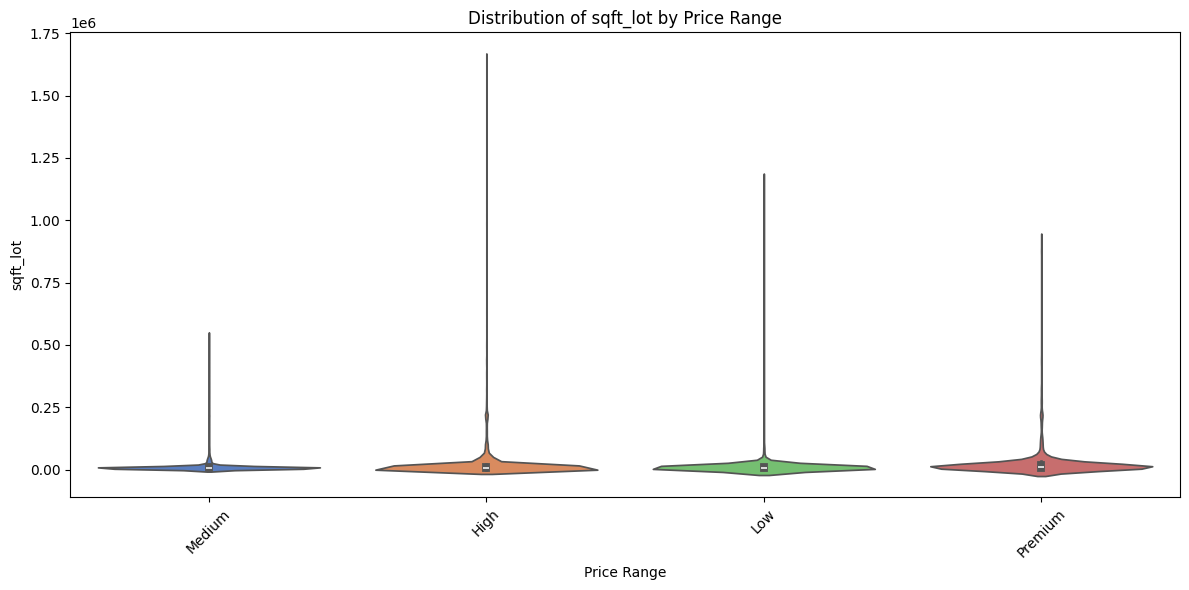

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


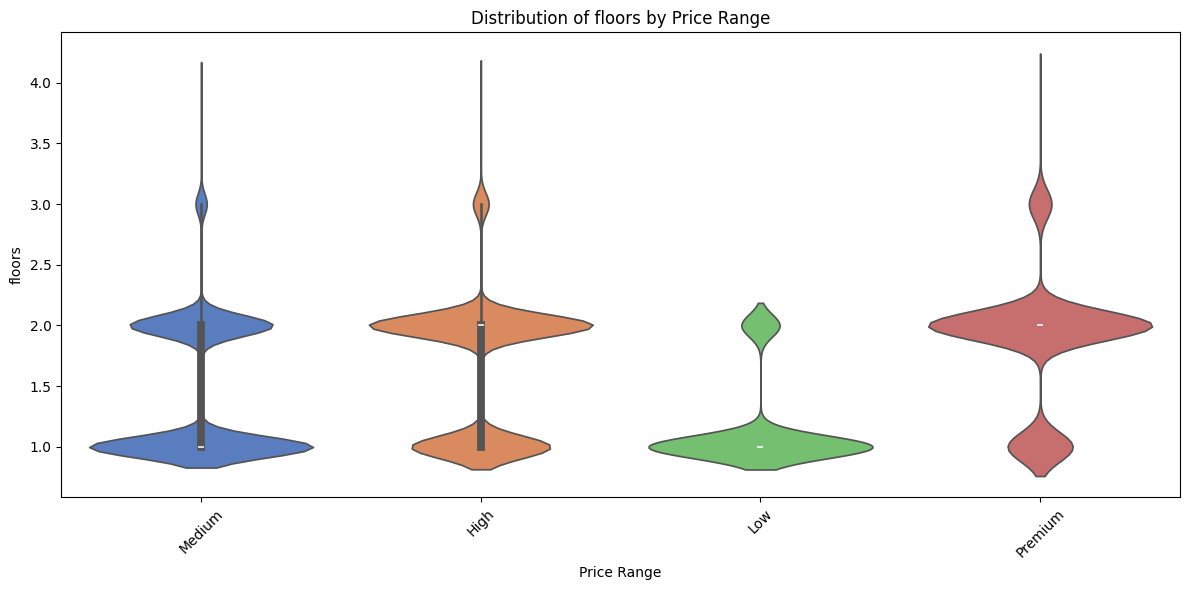

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


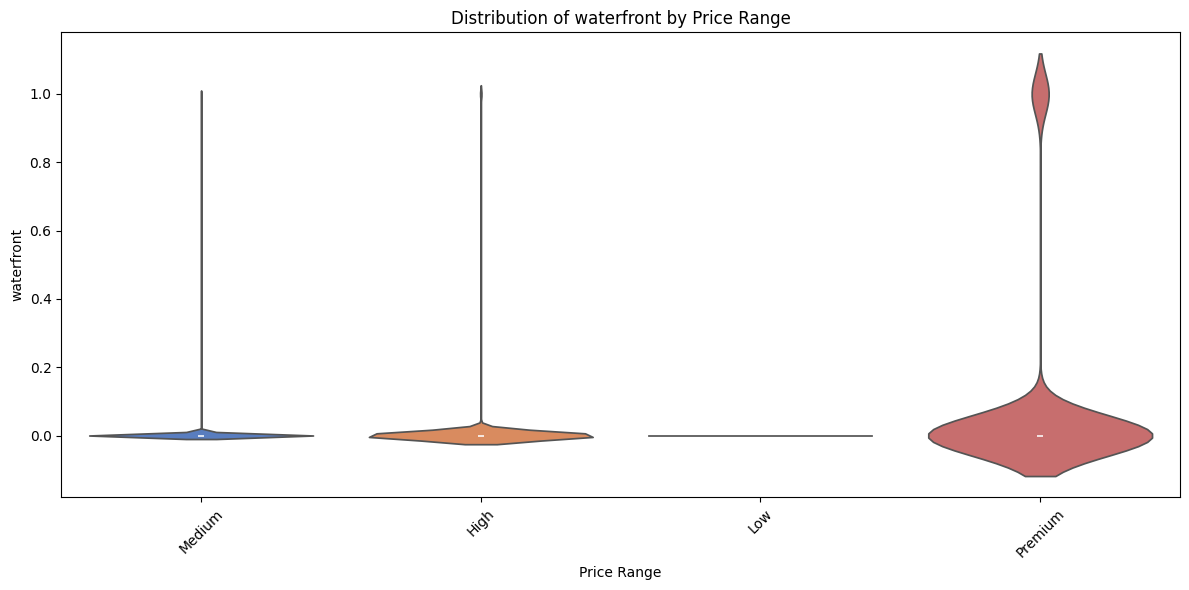

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


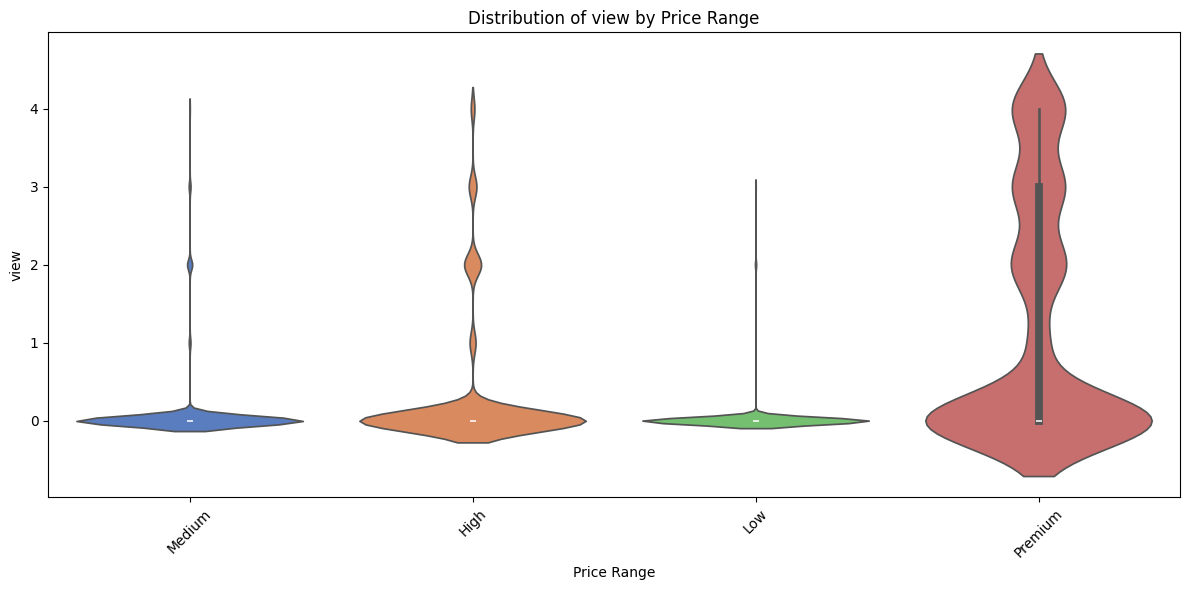

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


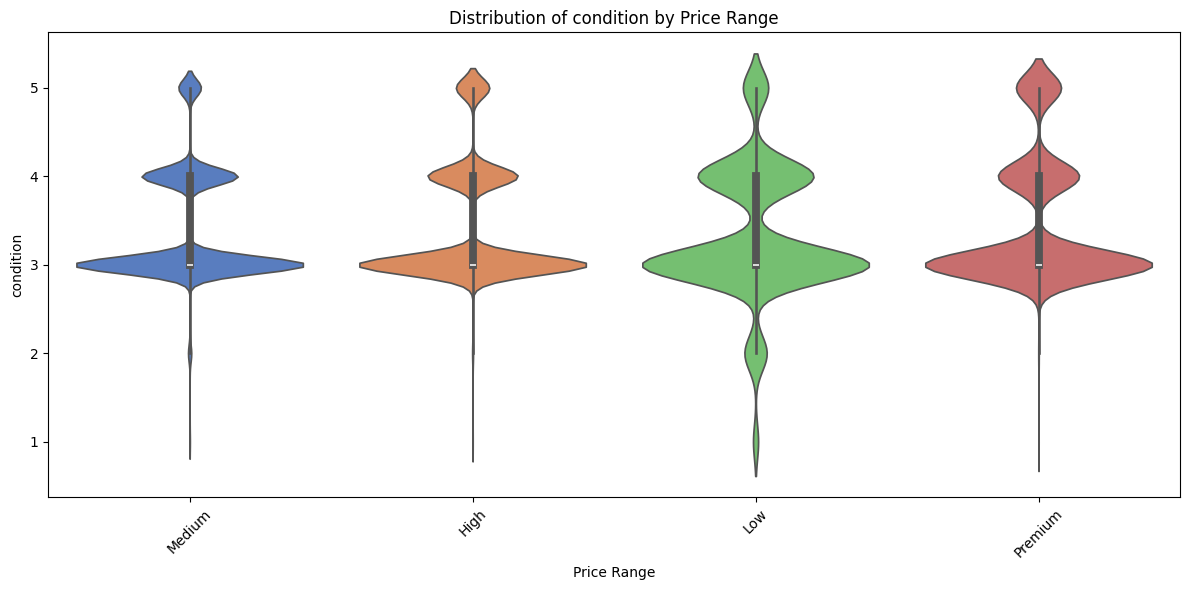

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


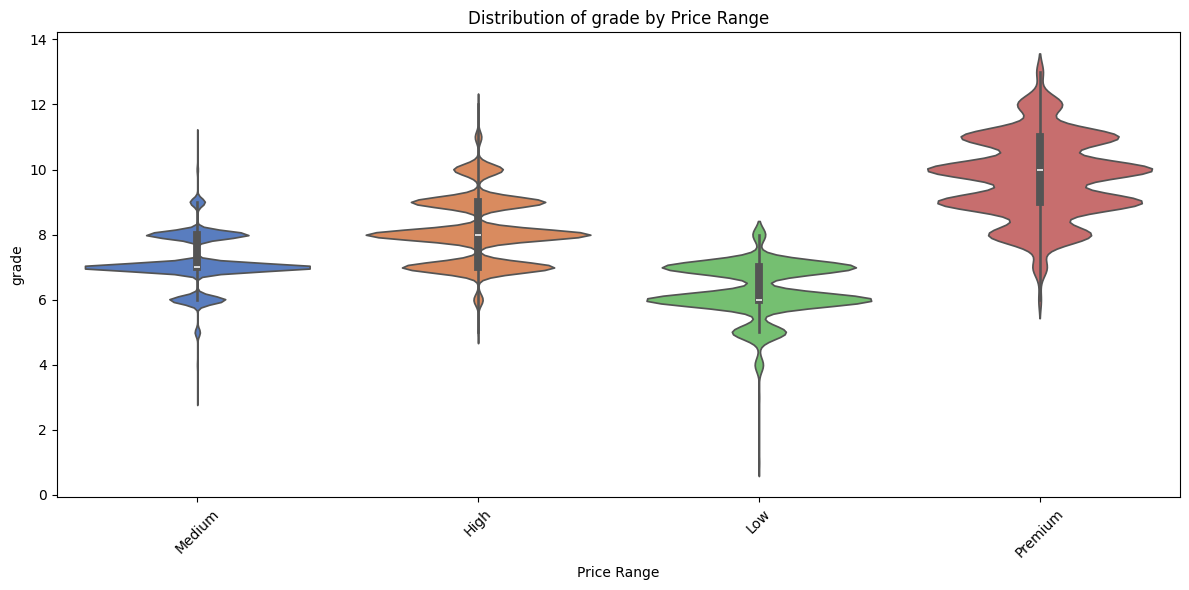

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


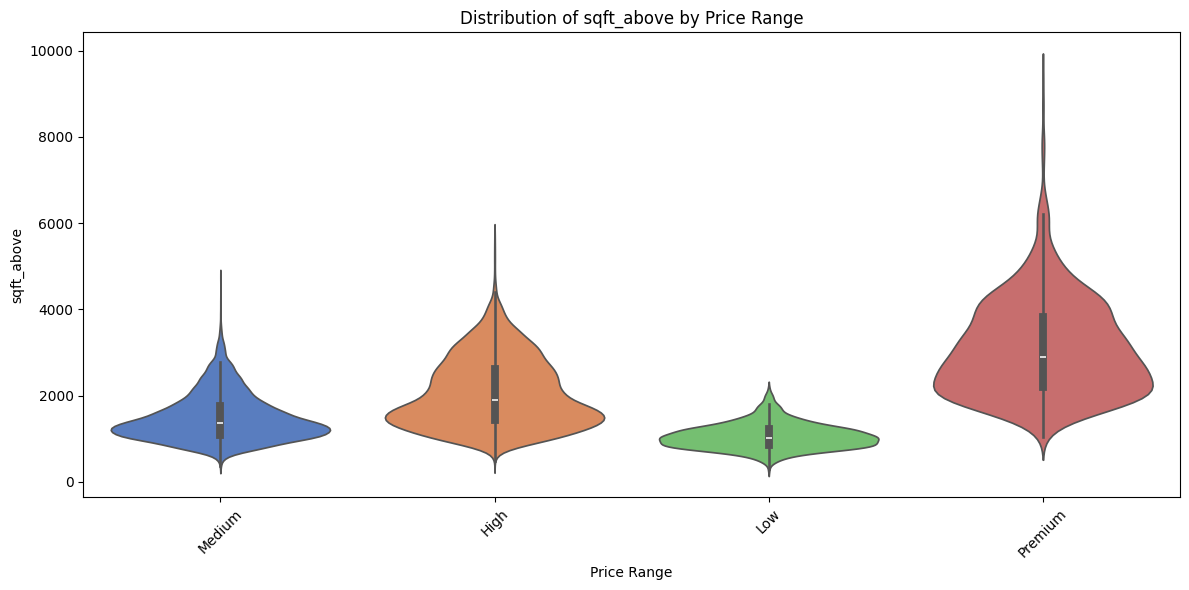

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


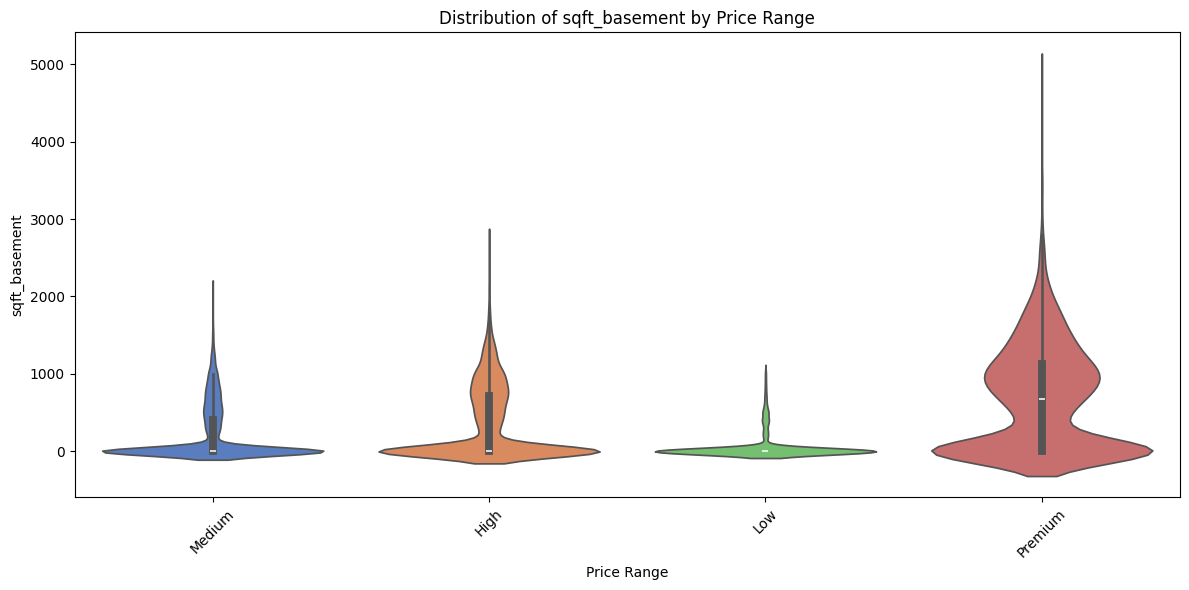

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


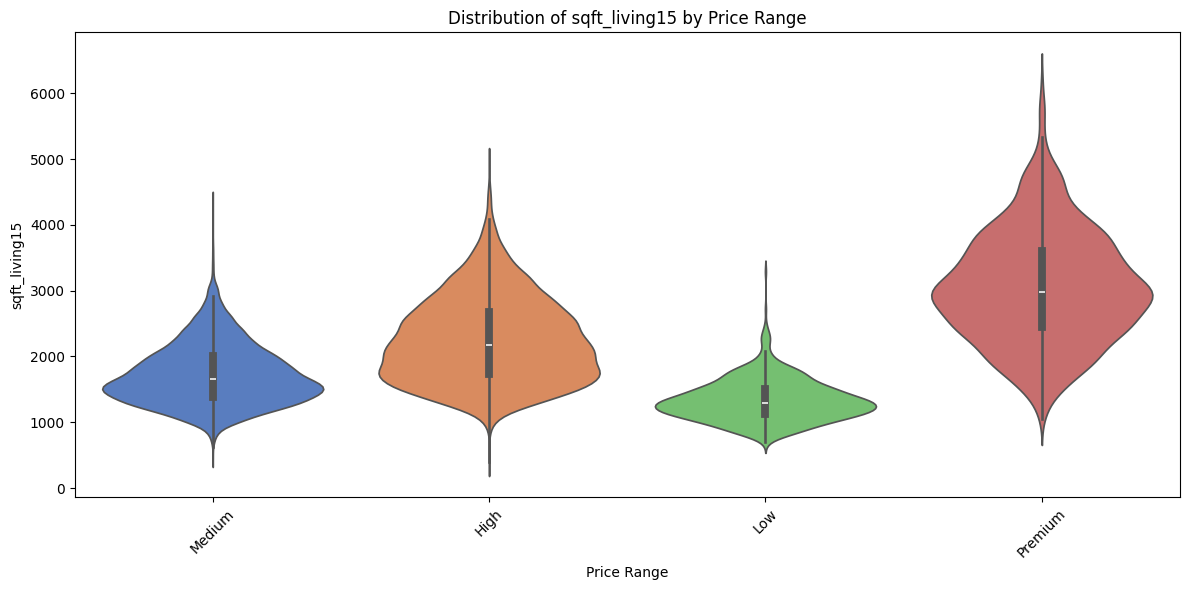

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


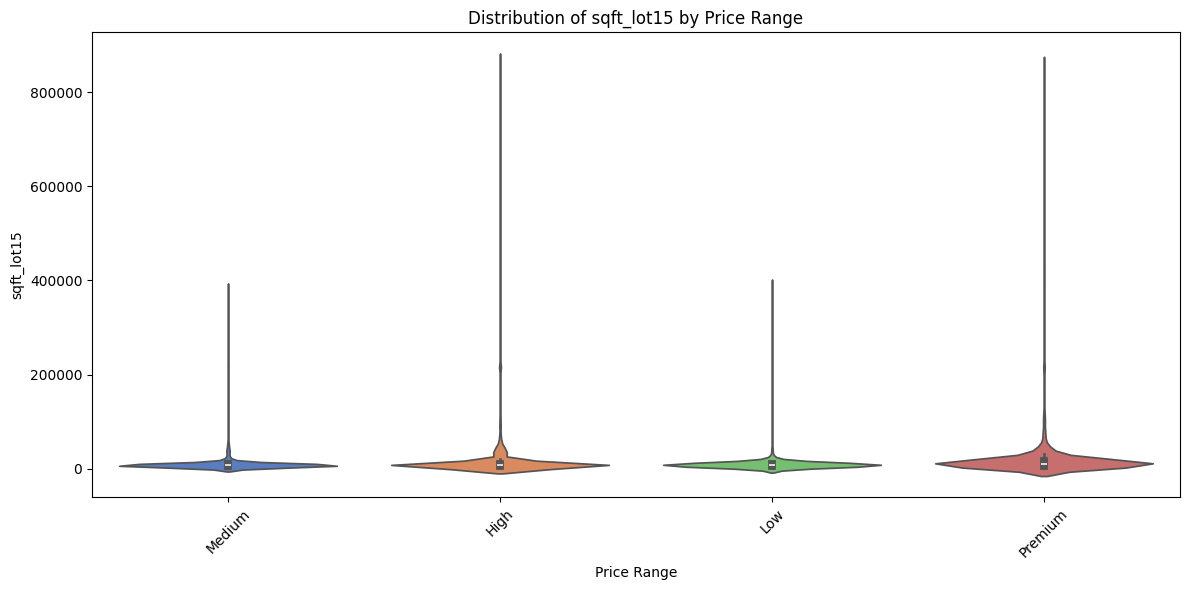

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


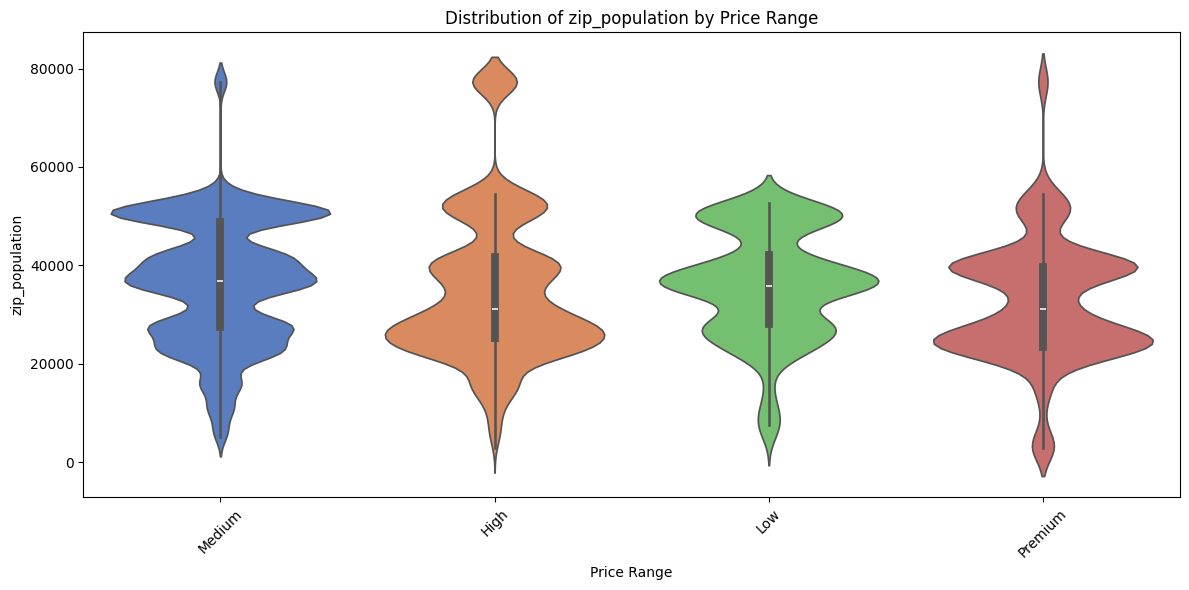

C:\Users\charl\AppData\Local\Temp\ipykernel_16944\2391467997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="price_range", y=column, palette="muted")


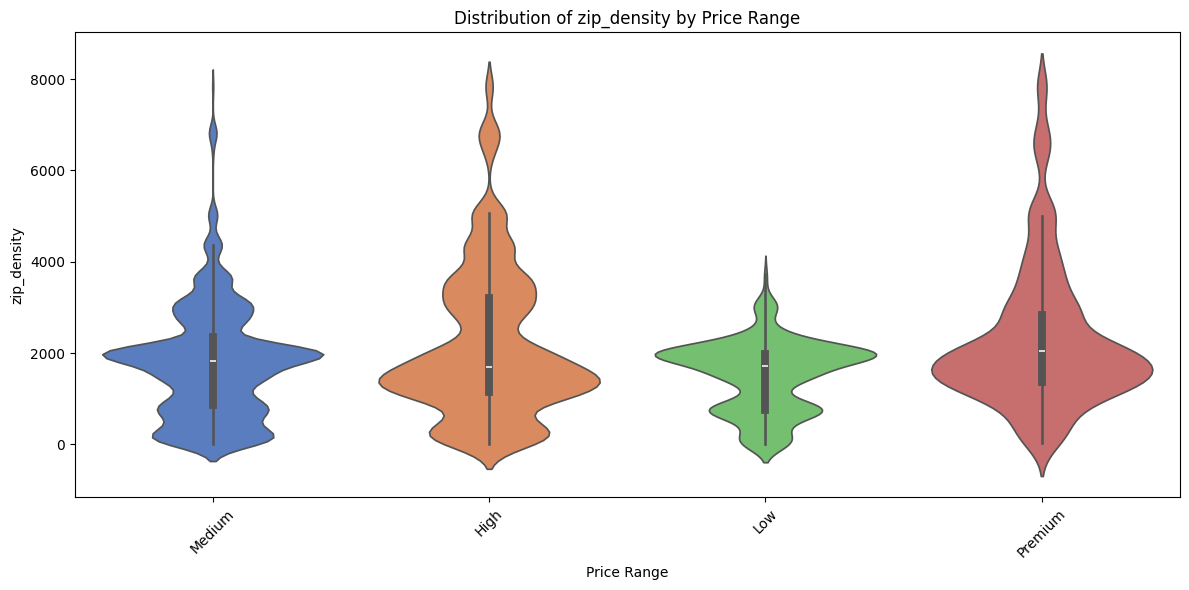

In [56]:
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=data, x="price_range", y=column, palette="muted")
    plt.title(f"Distribution of {column} by Price Range")
    plt.xlabel("Price Range")
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Régression

## Sélection des colonnes

In [57]:
features_corr_price = corr_df['price'][corr_df['price'].abs() >= 0.0].index.tolist()
features_corr_price.remove('price')
print(features_corr_price)

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'number_of_days', 'age_house', 'year_since_renovation', 'zip_population', 'zip_density', 'adjusted_gross_income_average', 'wages_and_salaries_average', 'dividends_average', 'interest_received_average']


In [58]:
assembler = VectorAssembler(inputCols=features_corr_price, outputCol="features_vector")
df_vector = assembler.transform(dfs_house)

scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features")
scaler_model = scaler.fit(df_vector)
df_normalized = scaler_model.transform(df_vector)

df_normalized.select("scaled_features").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                                                                                                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [59]:
df_vector.persist(StorageLevel.MEMORY_AND_DISK).count()

21586

In [60]:
train_data, test_data = df_vector.randomSplit([0.8, 0.2], seed=2024)

In [61]:
lr = LinearRegression(featuresCol="features_vector", labelCol="price")
lr_model = lr.fit(train_data)

In [62]:
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

In [63]:
predictions.persist(StorageLevel.MEMORY_AND_DISK).count()

4276

In [64]:
rmse = evaluator.evaluate(predictions)
print(f"RMSE on test data: {rmse}")

RMSE on test data: 175896.23050473863


In [65]:
predictions.select("features_vector", "price", "prediction").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-------------------+
|features_vector                                                                                                                                                            |price  |prediction         |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-------------------+
|[1.0,1.0,430.0,5050.0,1.0,0.0,0.0,2.0,4.0,430.0,0.0,1200.0,7500.0,22.0,102.0,102.0,7626.0,33.8,58068.818713450295,43357.897660818715,1219.076023391813,2132.5701754385964] |80000.0|-101329.37798892334|
|[2.0,1.0,520.0,22334.0,1.0,0.0,0.0,2.0,5.0,520.0,0.0,1572.0,10570.0,7.0,63.0,63.0,35050.0,1545.7,147344.08803611738,125319.91309255079,696.9808126410835,6727.477426636568]|82500.0|-55147.7555

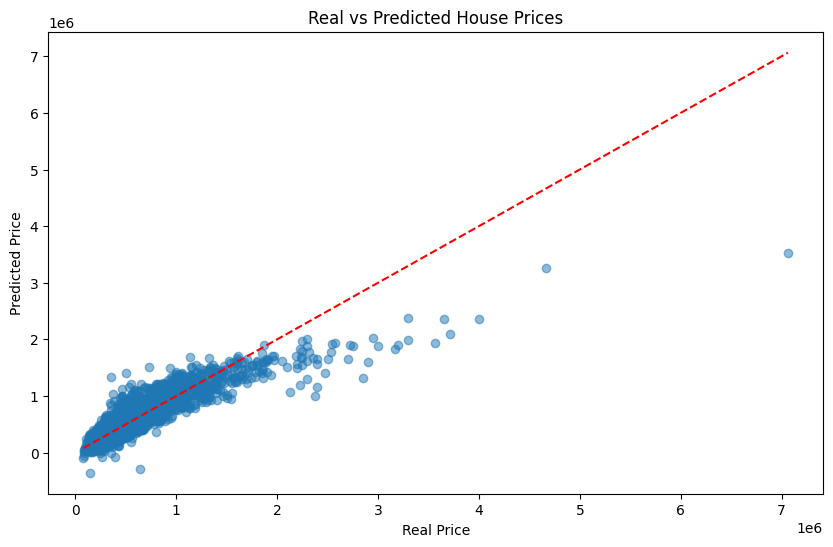

In [66]:
df_pandas = predictions.select("price", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df_pandas['price'], df_pandas['prediction'], alpha=0.5)
plt.plot([df_pandas['price'].min(), df_pandas['price'].max()], [df_pandas['price'].min(), df_pandas['price'].max()], 'r--')  # Line y=x
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Real vs Predicted House Prices')
plt.show()

In [67]:
evaluator = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="r2"
)

# Calculate R^2
r2 = evaluator.evaluate(predictions)
print(f"R^2 on test data: {r2}")

R^2 on test data: 0.7819633094284812


## Try improving normality

In [68]:
dfs_house = dfs_house.withColumn("log_price", F.log("price"))
dfs_house.printSchema()

root
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- number_of_days: integer (nullable = true)
 |-- age_house: integer (nullable = true)
 |-- year_since_renovation: integer (nullable = true)
 |-- zip_population: integer (nullable = true)
 |-- zip_density: double (nullable = true)
 |-- adjusted_gross_income_average: double (nullable = true)
 |-- wages_and_salaries_average: double (nullable = true)
 |-- dividends_average: double (nullable = true)
 |-- interes

In [69]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[price: double, bedrooms: int, bathrooms: int, sqft_living: int, sqft_lot: int, floors: int, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, sqft_living15: int, sqft_lot15: int, number_of_days: int, age_house: int, year_since_renovation: int, zip_population: int, zip_density: double, adjusted_gross_income_average: double, wages_and_salaries_average: double, dividends_average: double, interest_received_average: double, price_range: string, log_price: double]

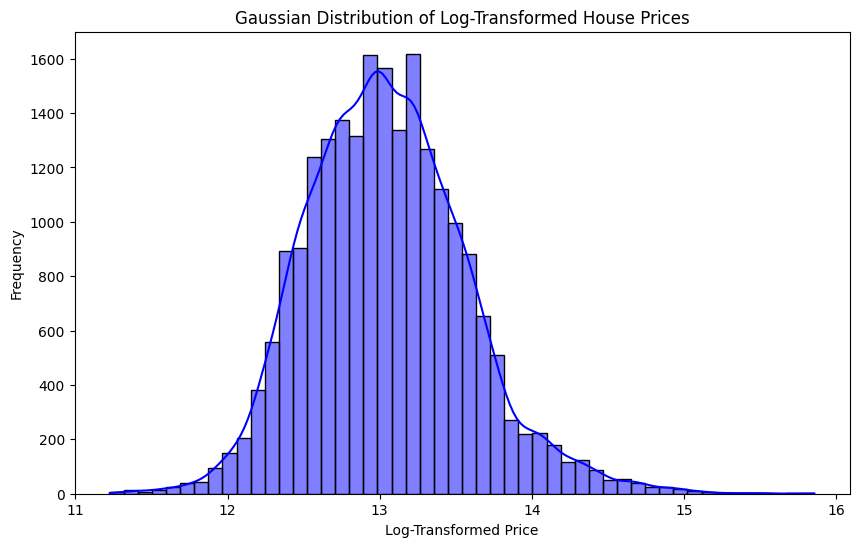

In [70]:
log_price_pandas = dfs_house.select("log_price").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(log_price_pandas["log_price"], kde=True, bins=50, color='blue')
plt.title("Gaussian Distribution of Log-Transformed House Prices")
plt.xlabel("Log-Transformed Price")
plt.ylabel("Frequency")
plt.show()

Now we can see that the distribution seems more gaussian

In [71]:
assembler = VectorAssembler(inputCols=features_corr_price, outputCol="features_unscaled")
dfs_house = assembler.transform(dfs_house)

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(dfs_house)
dfs_house = scaler_model.transform(dfs_house)

In [72]:
dfs_house.persist(StorageLevel.MEMORY_AND_DISK).count()

21586

In [73]:
train_data, test_data = dfs_house.randomSplit([0.8, 0.2], seed=42)
train_data.persist(StorageLevel.MEMORY_AND_DISK)
test_data.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[price: double, bedrooms: int, bathrooms: int, sqft_living: int, sqft_lot: int, floors: int, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, sqft_living15: int, sqft_lot15: int, number_of_days: int, age_house: int, year_since_renovation: int, zip_population: int, zip_density: double, adjusted_gross_income_average: double, wages_and_salaries_average: double, dividends_average: double, interest_received_average: double, price_range: string, log_price: double, features_unscaled: vector, features: vector]

In [74]:
lr = LinearRegression(featuresCol="features", labelCol="log_price", predictionCol="prediction")
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
rmse_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)

# Print the results
print(f"R² on test data: {r2}")
print(f"RMSE on test data: {rmse}")

# Print model coefficients and intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

R² on test data: 0.808873410022412
RMSE on test data: 0.22597877797290641
Coefficients: [0.0005499888260333412,0.03617291643677635,0.07761651453943158,0.023647833594441135,0.0056457048439130355,0.03625902702760795,0.039487190355195385,0.03685153355406315,0.13110829464922294,0.07216818461687438,0.027050854977542813,0.06427843672996908,0.006567644742830112,0.022179745412615953,0.07209651067014217,-0.0330499041834599,-0.1374472996952976,0.13531079026486675,-0.43134449374015366,0.3996722983502123,0.13889754117114234,0.15505104174002815]
Intercept: 13.045824739891604


In [75]:
import numpy as np

In [76]:
predictions.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[price: double, bedrooms: int, bathrooms: int, sqft_living: int, sqft_lot: int, floors: int, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, sqft_living15: int, sqft_lot15: int, number_of_days: int, age_house: int, year_since_renovation: int, zip_population: int, zip_density: double, adjusted_gross_income_average: double, wages_and_salaries_average: double, dividends_average: double, interest_received_average: double, price_range: string, log_price: double, features_unscaled: vector, features: vector, prediction: double]

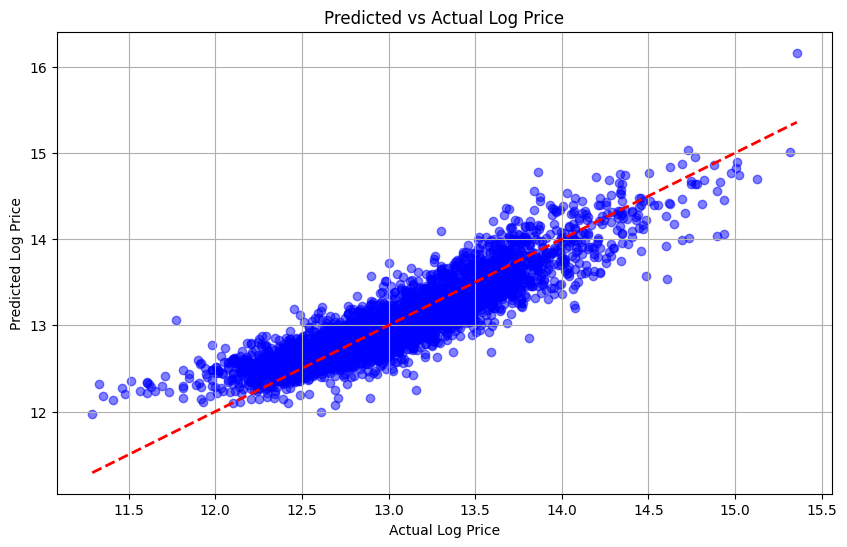

In [77]:
predictions_pandas = predictions.select("prediction", "log_price").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas["log_price"], predictions_pandas["prediction"], alpha=0.5, color="blue")
plt.plot([predictions_pandas["log_price"].min(), predictions_pandas["log_price"].max()],
         [predictions_pandas["log_price"].min(), predictions_pandas["log_price"].max()],
         color="red", linestyle="--", linewidth=2)
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title("Predicted vs Actual Log Price")
plt.grid()
plt.show()

In [78]:
predictions_pandas = predictions.select("prediction", "price", "log_price").toPandas()

predictions_pandas["predicted_price"] = np.exp(predictions_pandas["prediction"])
predictions_pandas["actual_price"] = predictions_pandas["price"]

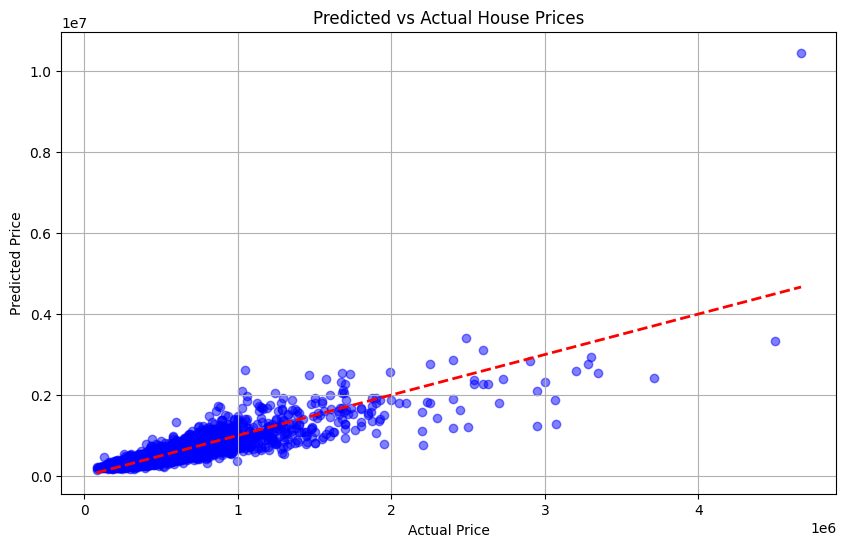

In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas["actual_price"], predictions_pandas["predicted_price"], alpha=0.5, color="blue")
plt.plot([predictions_pandas["actual_price"].min(), predictions_pandas["actual_price"].max()],
         [predictions_pandas["actual_price"].min(), predictions_pandas["actual_price"].max()],
         color="red", linestyle="--", linewidth=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual House Prices")
plt.grid()
plt.show()

## Drop outliers

In [85]:
custom_threshold = 3000000
dfs_house_filtered = dfs_house.filter(F.col("price") <= custom_threshold)

# Show the updated dataset
print(f"Original Dataset Count: {dfs_house.count()}")
print(f"Filtered Dataset Count: {dfs_house_filtered.count()}")

Original Dataset Count: 21586
Filtered Dataset Count: 21541


In [86]:
dfs_house_filtered.persist(StorageLevel.MEMORY_AND_DISK).count()

21541

In [87]:
train_data, test_data = dfs_house_filtered.randomSplit([0.8, 0.2], seed=42)
train_data.persist(StorageLevel.MEMORY_AND_DISK).count()
test_data.persist(StorageLevel.MEMORY_AND_DISK).count()

4251

In [90]:
lr = LinearRegression(featuresCol="features", labelCol="log_price", predictionCol="prediction")
lr_model = lr.fit(train_data)

test_results = lr_model.evaluate(test_data)
print(f"R² on test data: {test_results.r2}")
print(f"RMSE on test data: {test_results.rootMeanSquaredError}")

R² on test data: 0.8043857397587176
RMSE on test data: 0.2251173980306823


In [93]:
predictions = lr_model.transform(test_data).select("log_price", "prediction")

In [94]:
predictions.show()

+------------------+------------------+
|         log_price|        prediction|
+------------------+------------------+
|11.289781913656018|11.967269566789208|
|11.326595886778735| 12.31968214874711|
|11.350406535472453| 12.17714054085046|
|11.407564949312402|12.133732701956758|
|11.461632170582678|12.272009490189118|
|11.477298287327077|12.204056269293671|
|11.512925464970229|12.348217913933572|
|11.566466231898259| 12.23709283075458|
|11.608235644774552| 12.32663845521995|
|11.608235644774552|12.219702052427476|
|11.608235644774552|12.342280904131924|
|11.614579118696728|12.312717664380394|
|11.626254150277232|12.282558827278256|
|11.652687407345388|12.242295709053655|
|11.691071650353702|12.300785672631578|
|11.711776323715394|12.412084766652926|
|11.733986850080113|12.228000724869705|
| 11.77528972943772| 13.05649349686208|
|11.813030057420567| 12.15668891564157|
|11.813030057420567|12.269039838133756|
+------------------+------------------+
only showing top 20 rows

